In [1]:
import os
import sys
import jax
import jax.numpy as np
import jax.tree as jtu
import jax.random as jr

# Basic jax import
jax.config.update("jax_enable_x64", True)

# Check if running on remote, and set directory to where notebook is run
if jax.devices()[0].platform == "gpu":
    os.chdir("code/amigo_project/notebooks/calibration")

# Add parent directories
paths = [os.path.abspath(os.path.join(os.getcwd(), path)) for path in ["..", "../.."]]
for path in paths:
    if path not in sys.path:
        sys.path.insert(0, path)

ERROR:2025-05-21 22:59:31,968:jax._src.xla_bridge:647: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/louis/miniconda3/envs/jax_gpu/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 645, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/home/louis/miniconda3/envs/jax_gpu/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 105, in initialize
    triton.register_compilation_handler(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'jax._src.lib.triton' has no attribute 'register_compilation_handler'


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
        
# Plotting set up
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = mpl.colormaps["inferno"]
seismic = mpl.colormaps["seismic"]
coolwarm = mpl.colormaps["coolwarm"]


inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)
coolwarm.set_bad("k", 0.5)


# Load our model and fitted visibilities

In [3]:
from amigo.optical_models import AMIOptics
from amigo.vis_models import LogVisModel

# Load the cached states
file_path = "../../GPU_files/"
load_dict = lambda x: np.load(f"{file_path}/{x}.npy", allow_pickle=True).item()
cal_values = load_dict("cal_files/cal_model")
vis_basis = load_dict("cal_files/vis_basis")
fit = load_dict("/results/GO1843/fit_outputs")
n_basis = fit.pop("n_basis")

optics = AMIOptics(psf_upsample=1)
vis_model = LogVisModel(vis_basis, n_basis=n_basis)

# Get the average aberrations per filter for the Kernel visibilities

In [4]:
# Sort the aberration values by their filter
filters = sorted(list(set([fit_values["filter"] for fit_values in fit.values()])))
aberrations = {k: [] for k in filters}
for exp_key, fit_values in fit.items():
    aberrations[fit_values["filter"]].append(fit_values["aberrations"])

# Get the mean aberration value per filter
leaf_fn = lambda x: isinstance(x, list)
list_mean = lambda x: np.array(x).mean(0)
aberrations = jtu.map(lambda x: list_mean(x), aberrations, is_leaf=leaf_fn)

# Calculate the Kernel visibilities

In [5]:
from amigo.stats import svd
from amigo.vis_calibration import vis_jac_fn
from amigo.core_models import ModelParams
from amigo.misc import tqdm
import dLux.utils as dlu


thresh = 1e-12
kernel_outputs = {}
for filt in tqdm(filters):
    optics = optics.set("defocus", cal_values["defocus"][filt])

    model_params = ModelParams(
        {
            # Note we dont need to marginalise over positions - its subsumed by abbs
            "defocus": cal_values["defocus"][filt],
            "spectra": np.zeros(1),
            "fluxes": np.zeros(1),
            "abb_coeffs": aberrations[filt],
        }
    )

    jac_fn = lambda X: vis_jac_fn(X, (optics, vis_model, filt))
    amp_fn, phase_fn = lambda X: jac_fn(X)[0], lambda X: jac_fn(X)[1]
    J_amp = model_params.jacfwd(amp_fn, n_batch=30)
    J_phase = model_params.jacfwd(phase_fn, n_batch=30)

    # Get the Jacobian decompositions
    u_amp, s_amp, vh_amp = svd(J_amp)
    u_phase, s_phase, vh_phase = svd(J_phase)

    n_amp = len(s_amp) - np.sum(s_amp < thresh)
    n_phase = len(s_phase) - np.sum(s_phase < thresh)

    kernel_outputs[filt] = {
        "kernel_mats": {
            "amplitudes": u_amp[:, n_amp:].T,
            "phases": u_phase[:, n_phase:].T,
        },
        "proj_mats": {
            "amplitudes": u_amp[:, :len(s_amp)].T,
            "phases": u_phase[:, :len(s_phase)].T,
        },
        "J_mats": {
            "amplitudes": J_amp,
            "phases": J_phase,
        },
        "singular_vals": {
            "amplitudes": s_amp,
            "phases": s_phase,
        },
    }

  0%|          | 0/3 [00:00<?, ?it/s]

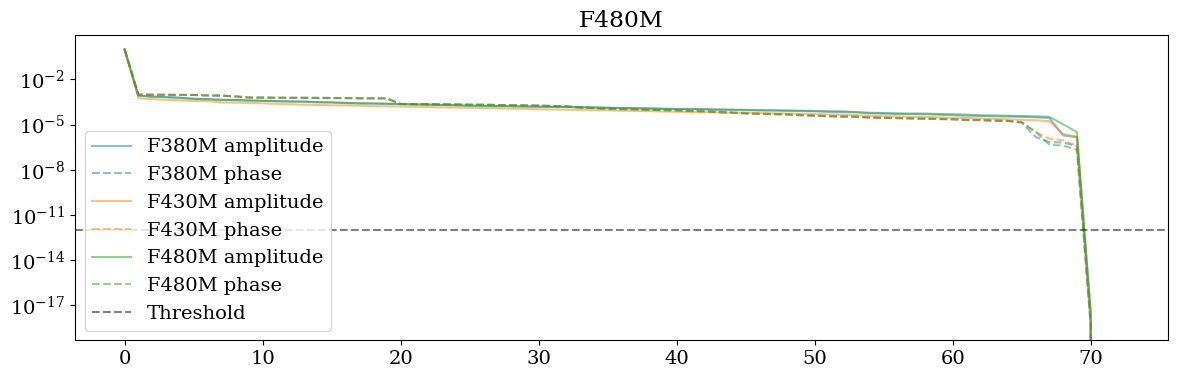

In [6]:
plt.figure(figsize=(12, 4))
for i, filt in enumerate(filters):
    s_amp = kernel_outputs[filt]["singular_vals"]["amplitudes"]
    s_phase = kernel_outputs[filt]["singular_vals"]["phases"]

    plt.title(filt)
    plt.plot(s_amp, label=f"{filt} amplitude", c=f"C{i}", alpha=0.5)
    plt.plot(s_phase, label=f"{filt} phase", ls="--", c=f"C{i}", alpha=0.5)
    plt.yscale("log")

plt.axhline(thresh, ls="--", c="k", alpha=0.5, label="Threshold")
plt.legend()
plt.tight_layout()
plt.show()

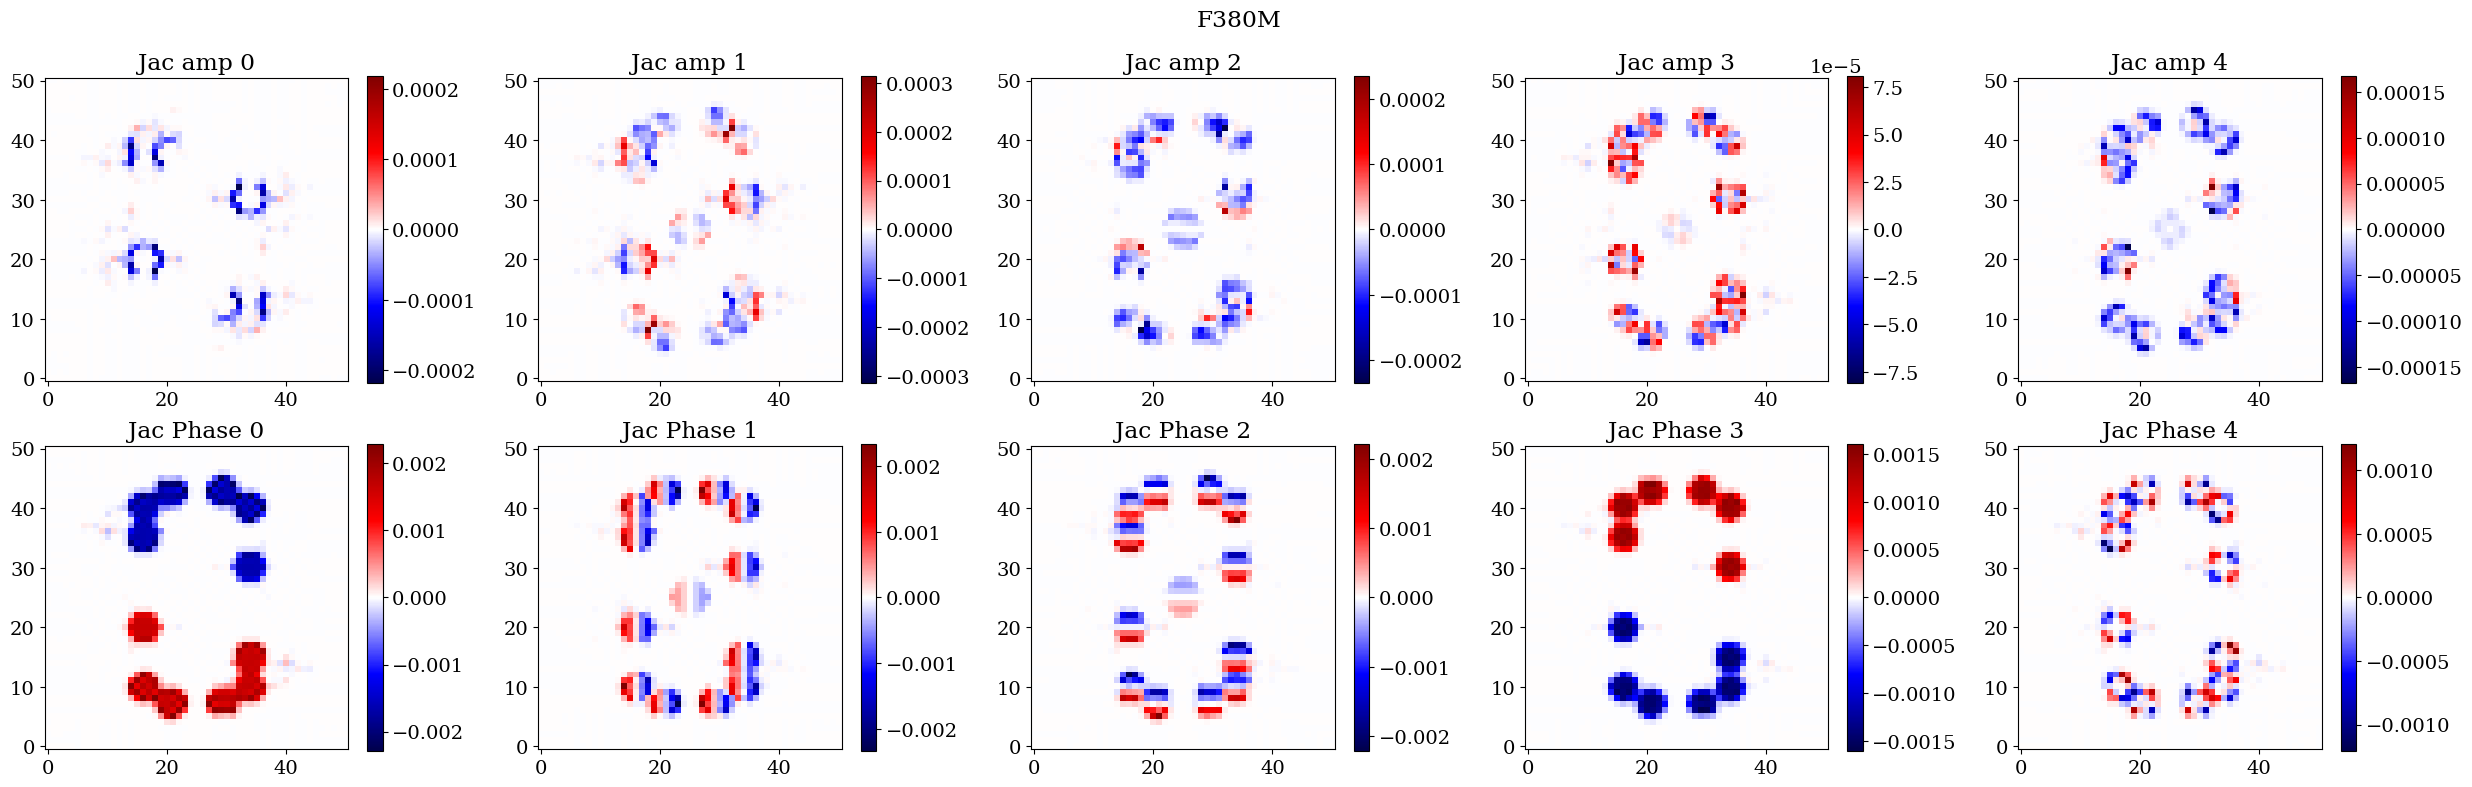

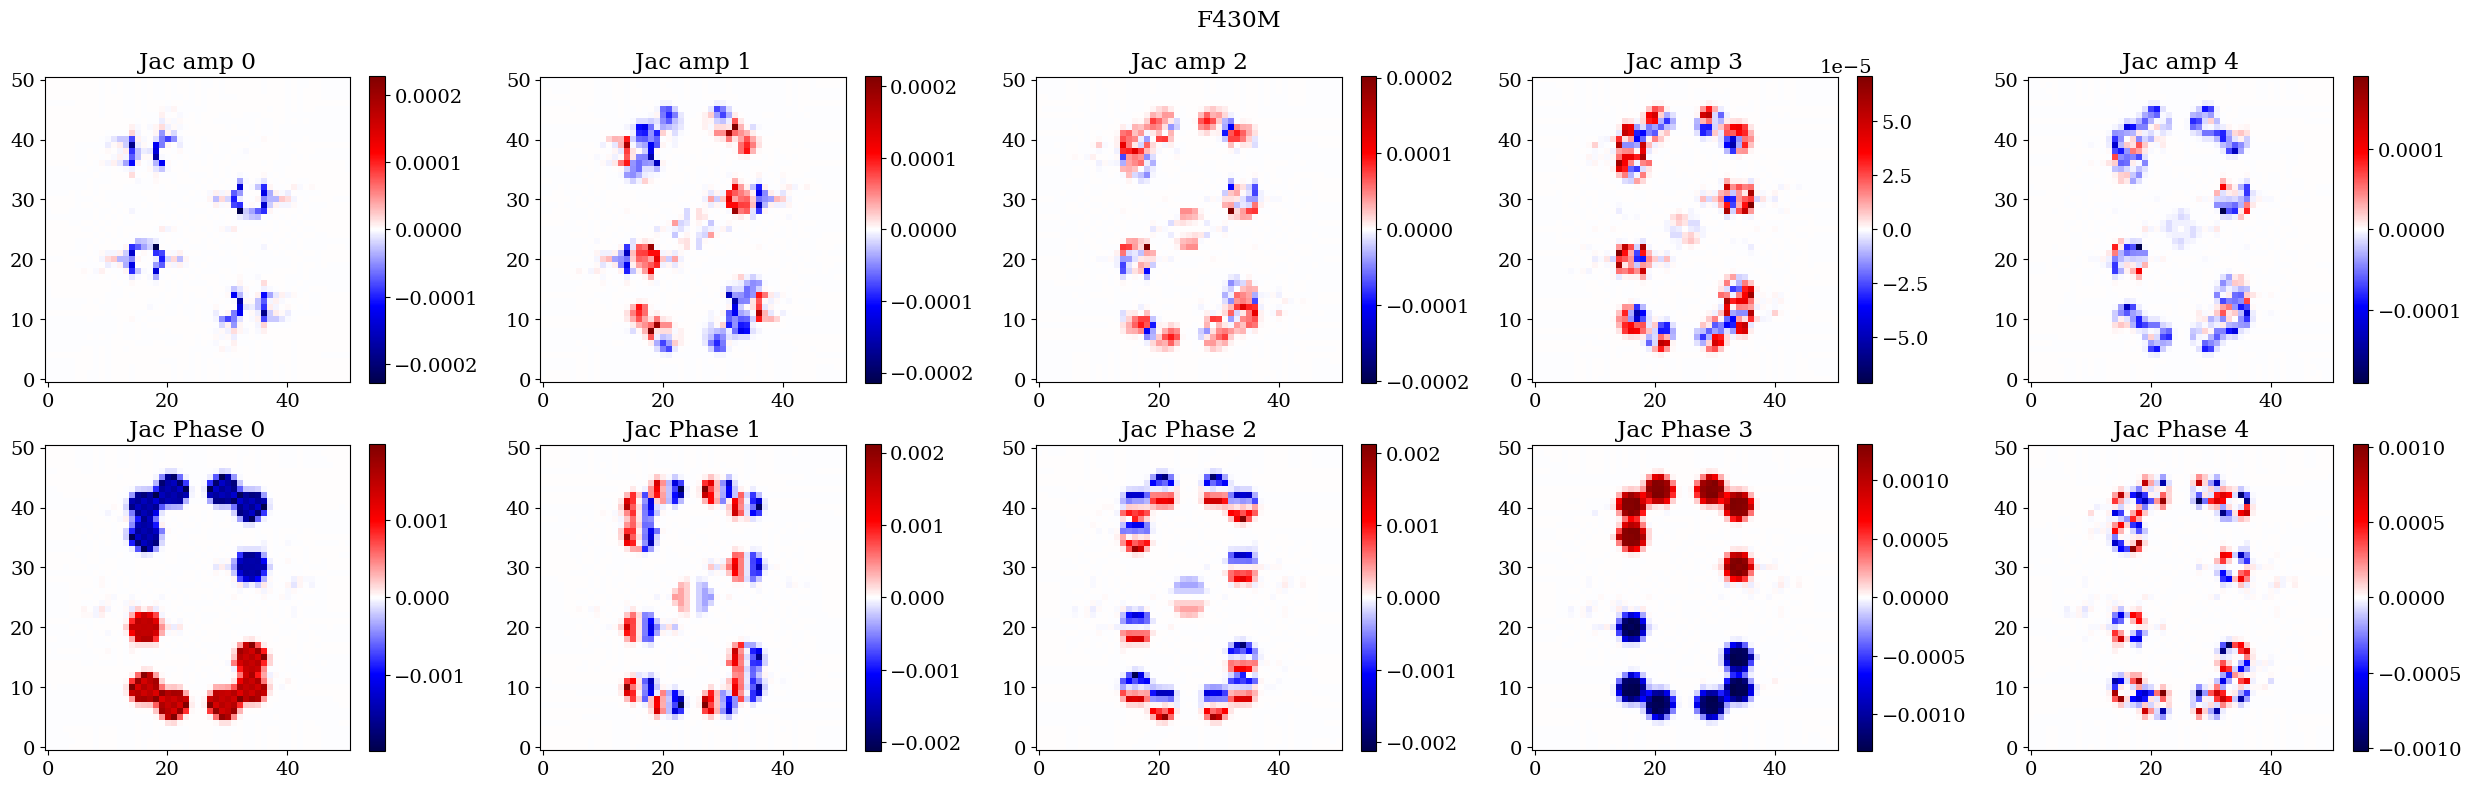

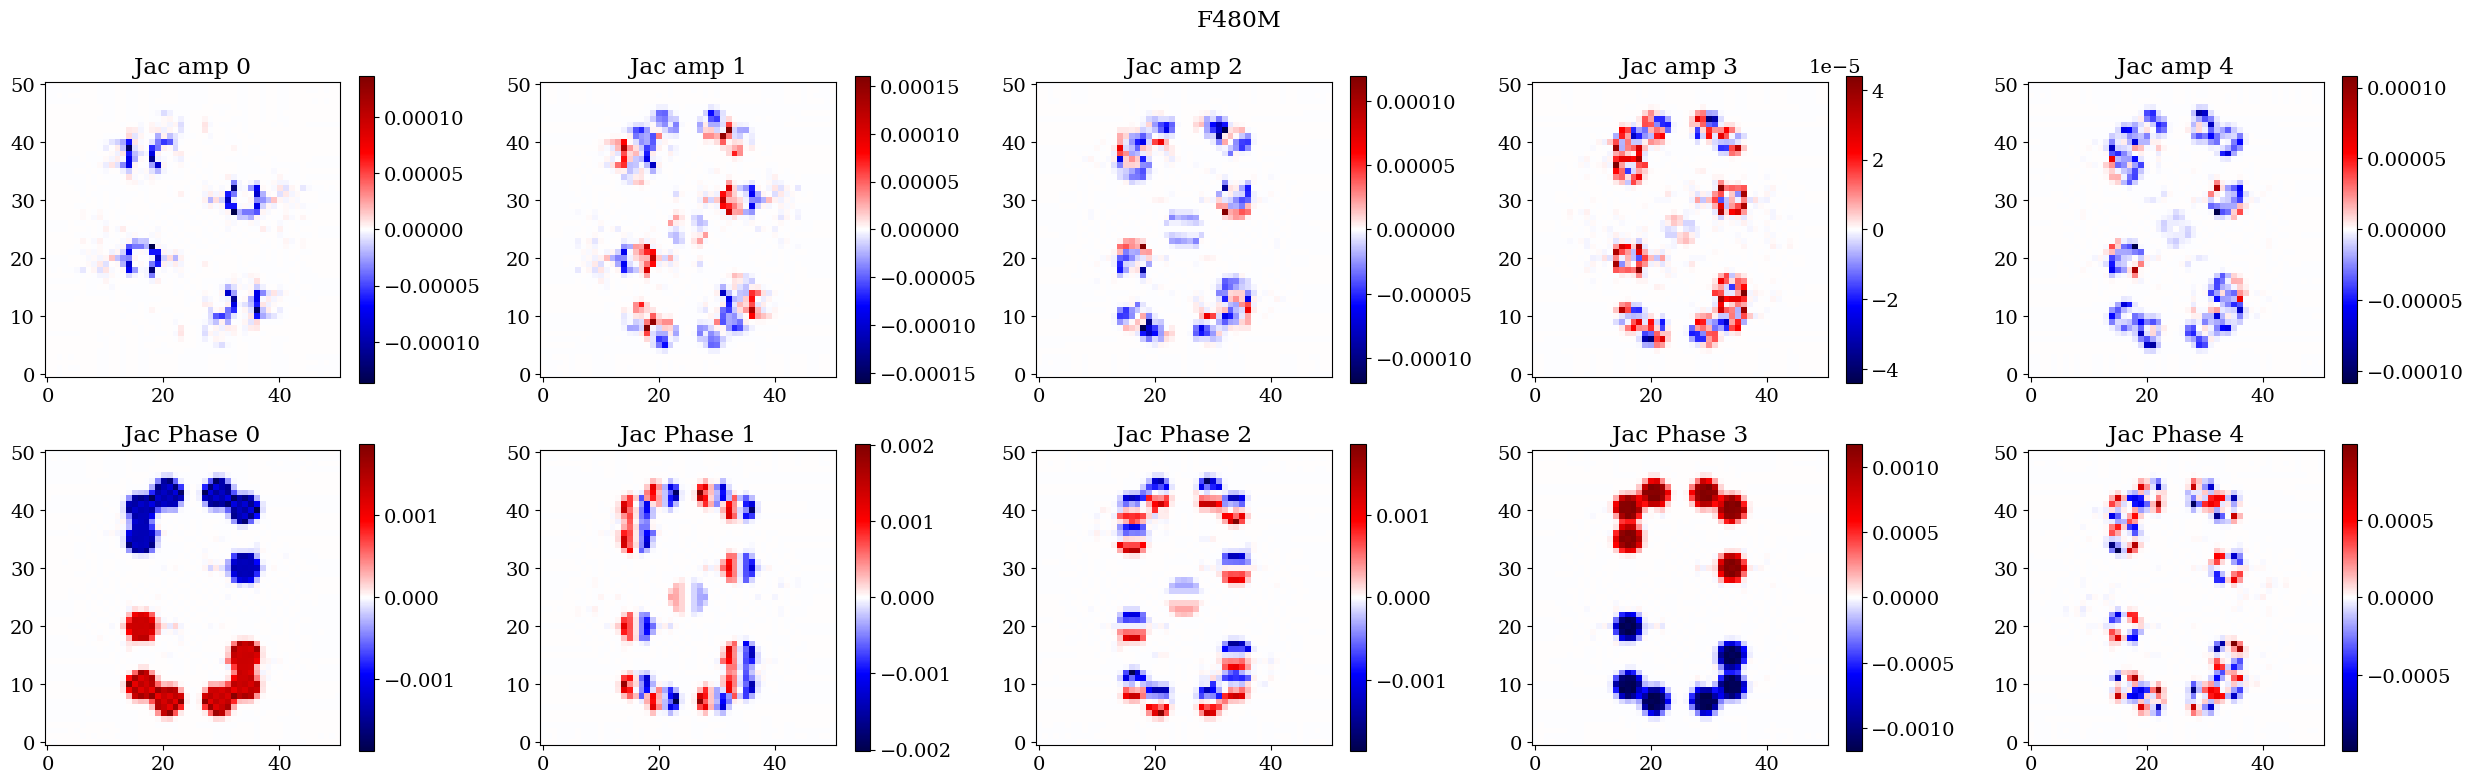

In [7]:
for filt in filters:
    lat_amp_Js = kernel_outputs[filt]["J_mats"]["amplitudes"]
    lat_phase_Js = kernel_outputs[filt]["J_mats"]["phases"]

    plt.figure(figsize=(25, 8))
    plt.suptitle(filt)
    for i in range(5):
        log_amp, phase = vis_model.latent_to_im(lat_amp_Js[:, i], lat_phase_Js[:, i], filt)

        v = np.nanmax(np.abs(log_amp))
        plt.subplot(2, 5, i + 1)
        plt.title(f"Jac amp {i}")
        plt.imshow(log_amp, seismic, vmin=-v, vmax=v)
        plt.colorbar()

        v = np.nanmax(np.abs(phase))
        plt.subplot(2, 5, i + 6)
        plt.title(f"Jac Phase {i}")
        plt.imshow(phase, seismic, vmin=-v, vmax=v)
        plt.colorbar()

    plt.tight_layout()
    plt.show()

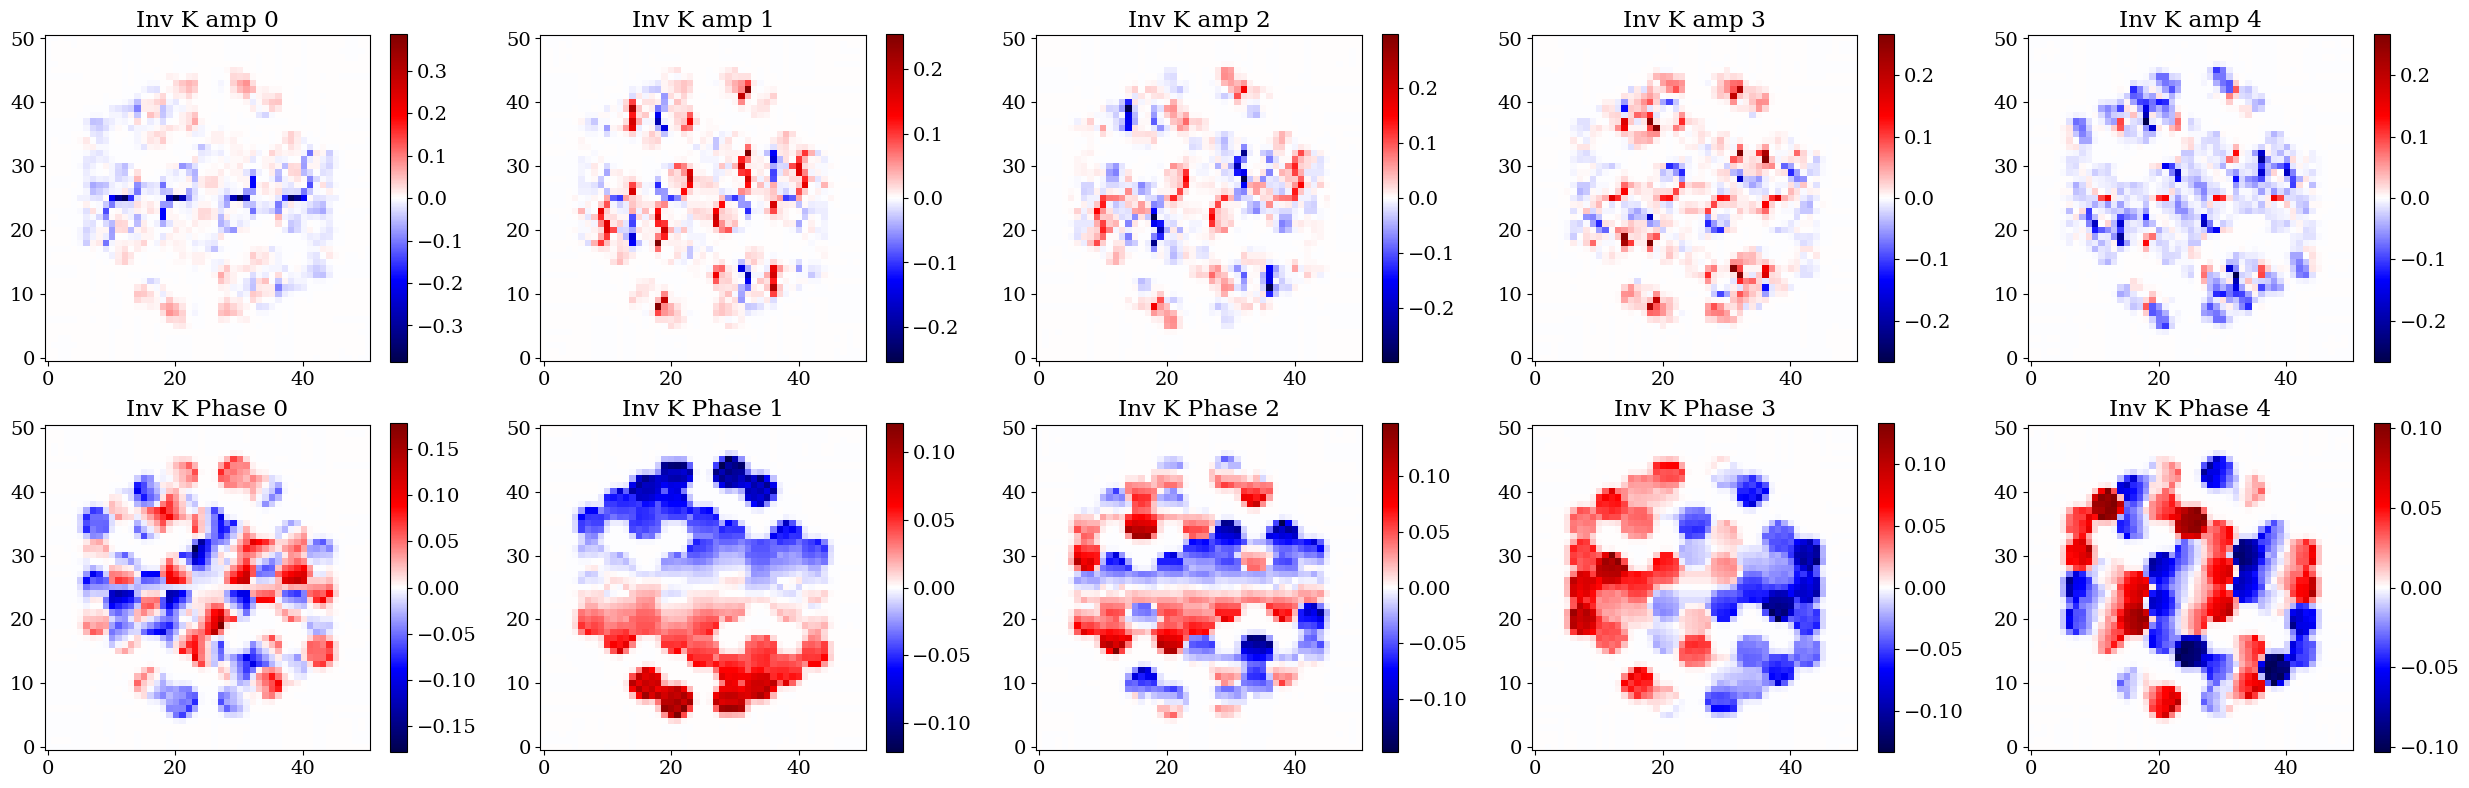

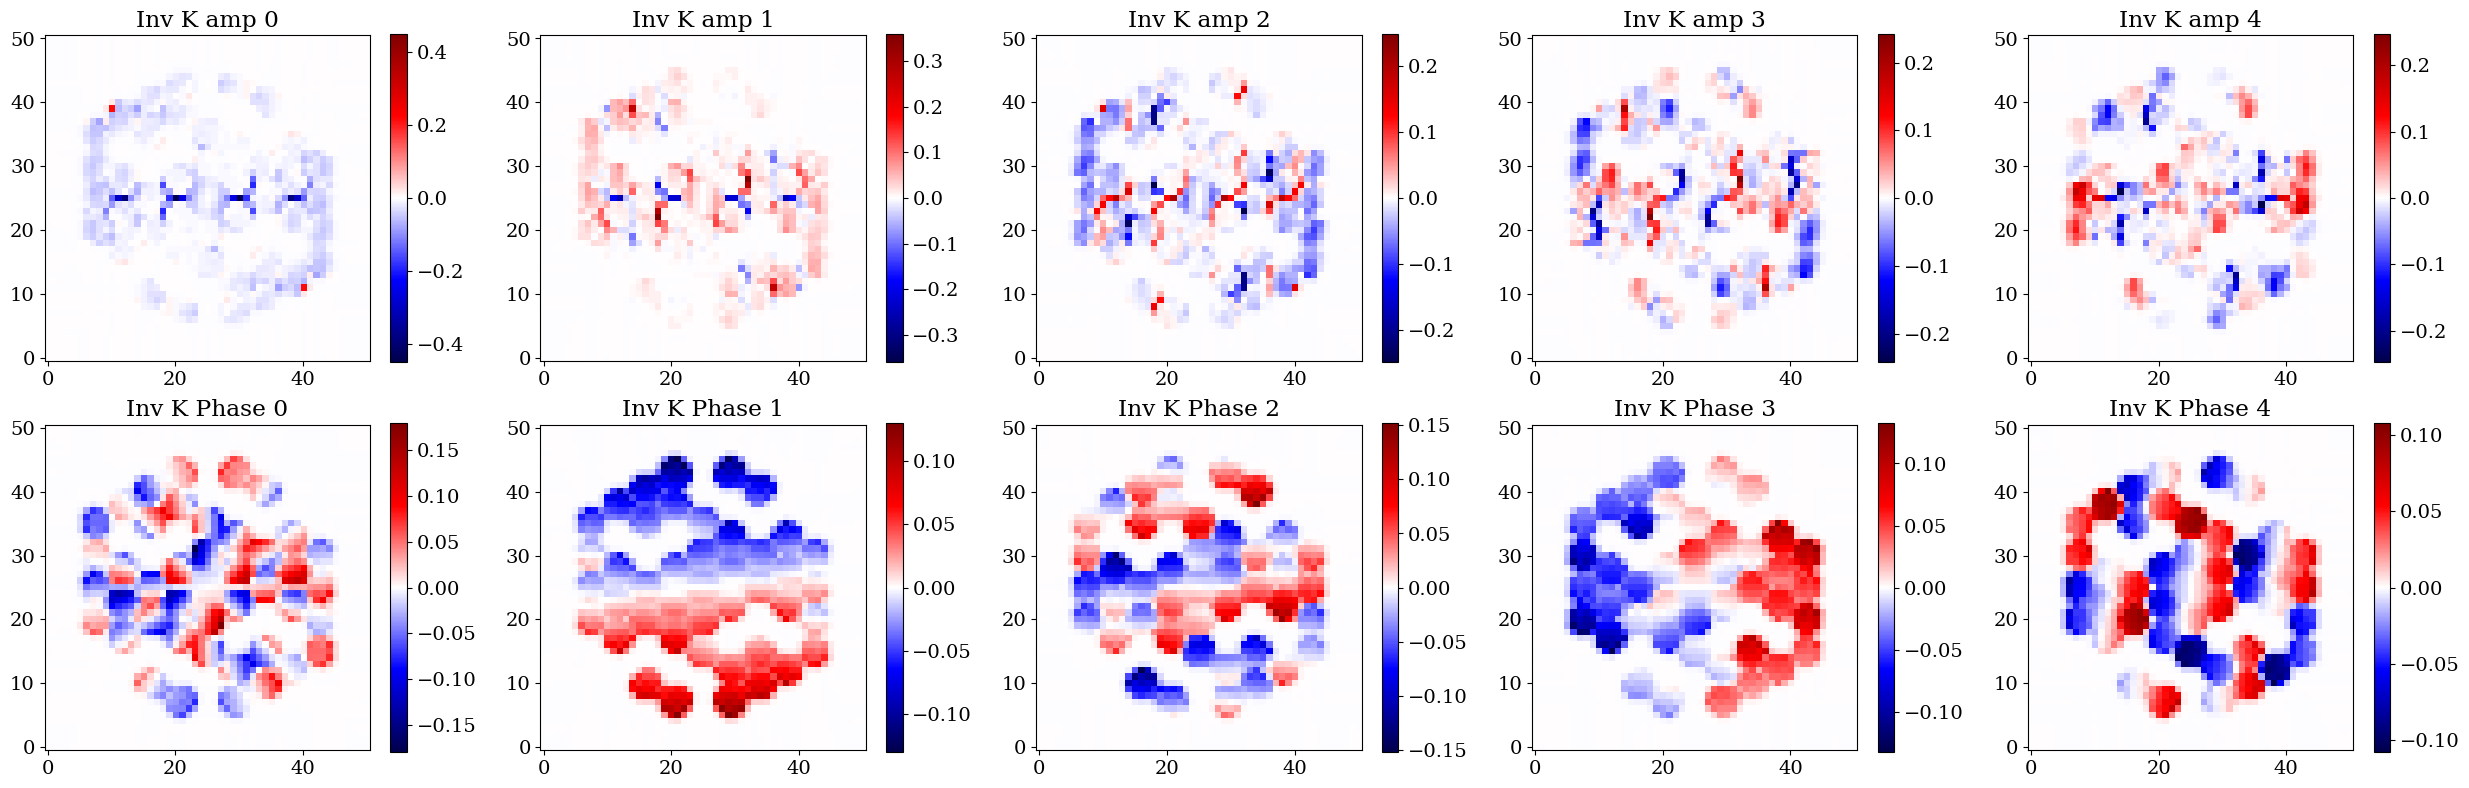

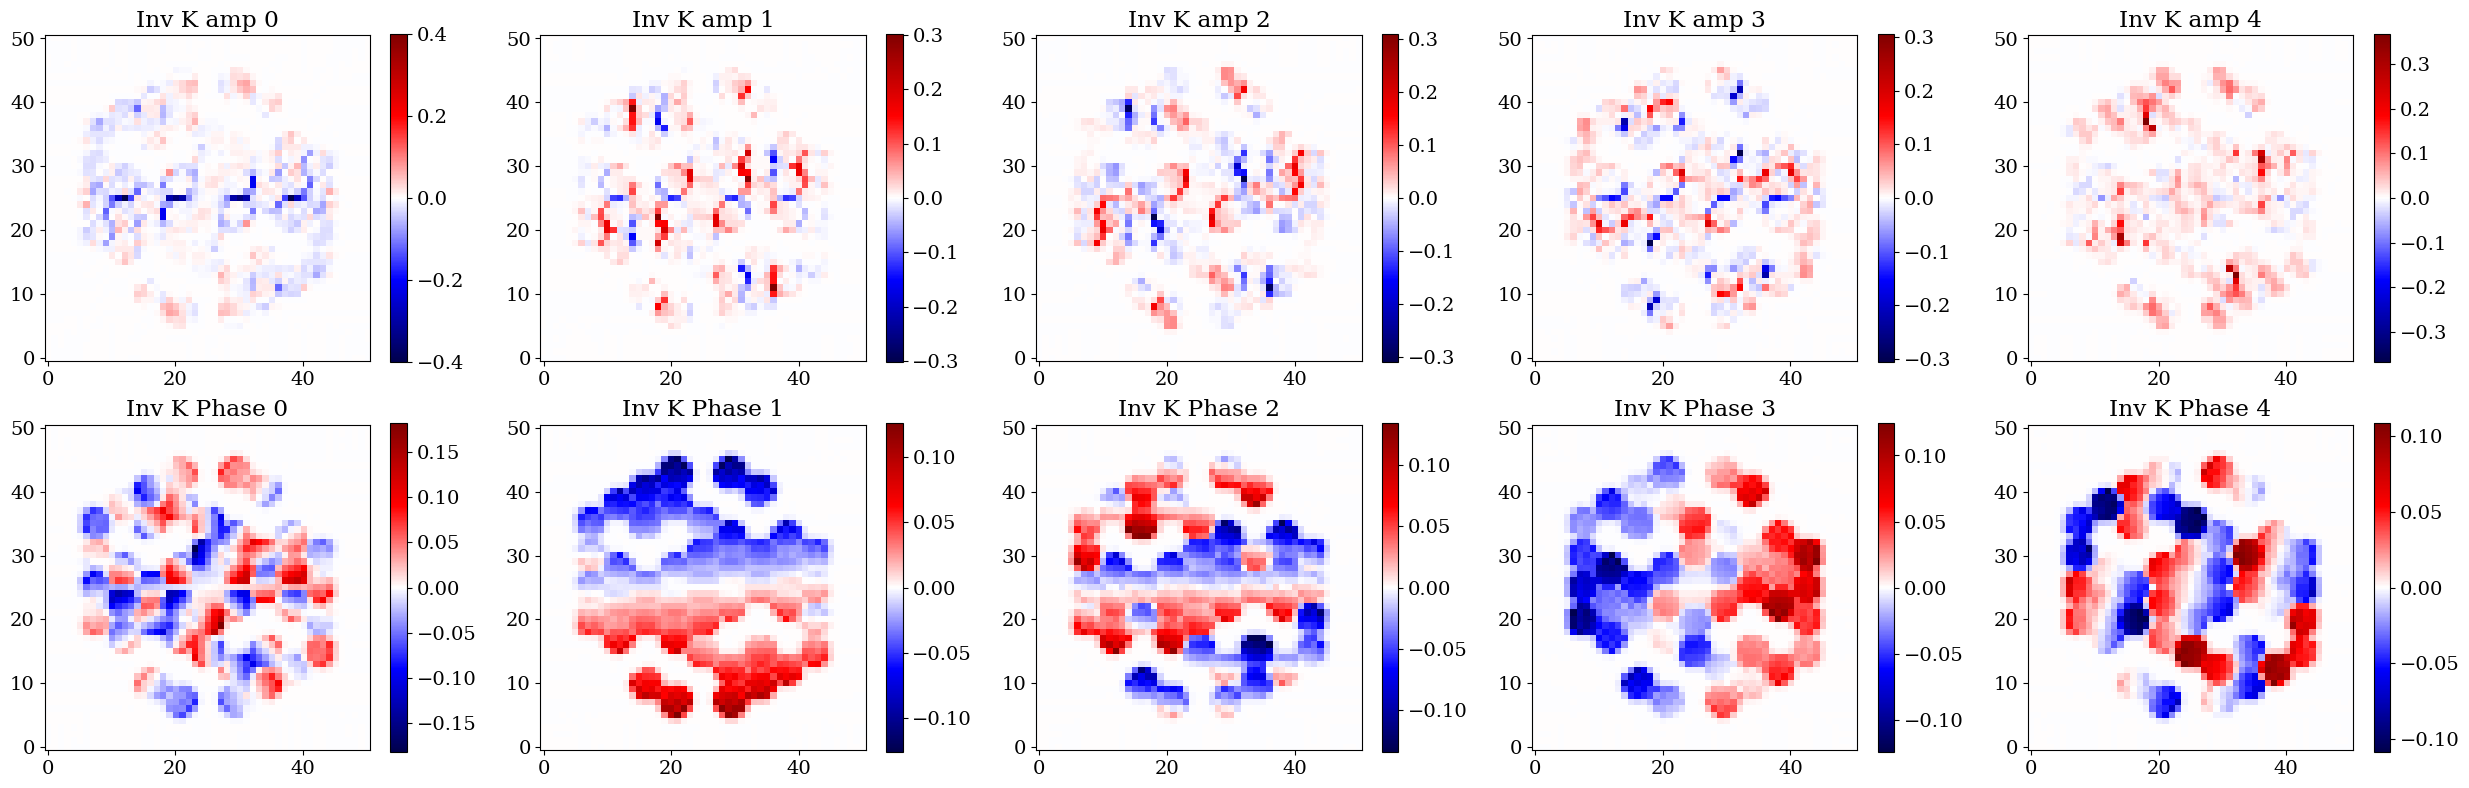

In [8]:
for filt in filters:
    amp_vecs = kernel_outputs[filt]["proj_mats"]["amplitudes"]
    phase_vecs = kernel_outputs[filt]["proj_mats"]["phases"]

    plt.figure(figsize=(25, 8))
    for i in range(5):
        log_amp, phase = vis_model.latent_to_im(amp_vecs[i], phase_vecs[i], filt)

        v = np.nanmax(np.abs(log_amp))
        plt.subplot(2, 5, i + 1)
        plt.title(f"Inv K amp {i}")
        plt.imshow(log_amp, seismic, vmin=-v, vmax=v)
        plt.colorbar()

        v = np.nanmax(np.abs(phase))
        plt.subplot(2, 5, i + 6)
        plt.title(f"Inv K Phase {i}")
        plt.imshow(phase, seismic, vmin=-v, vmax=v)
        plt.colorbar()

    plt.tight_layout()
    plt.show()

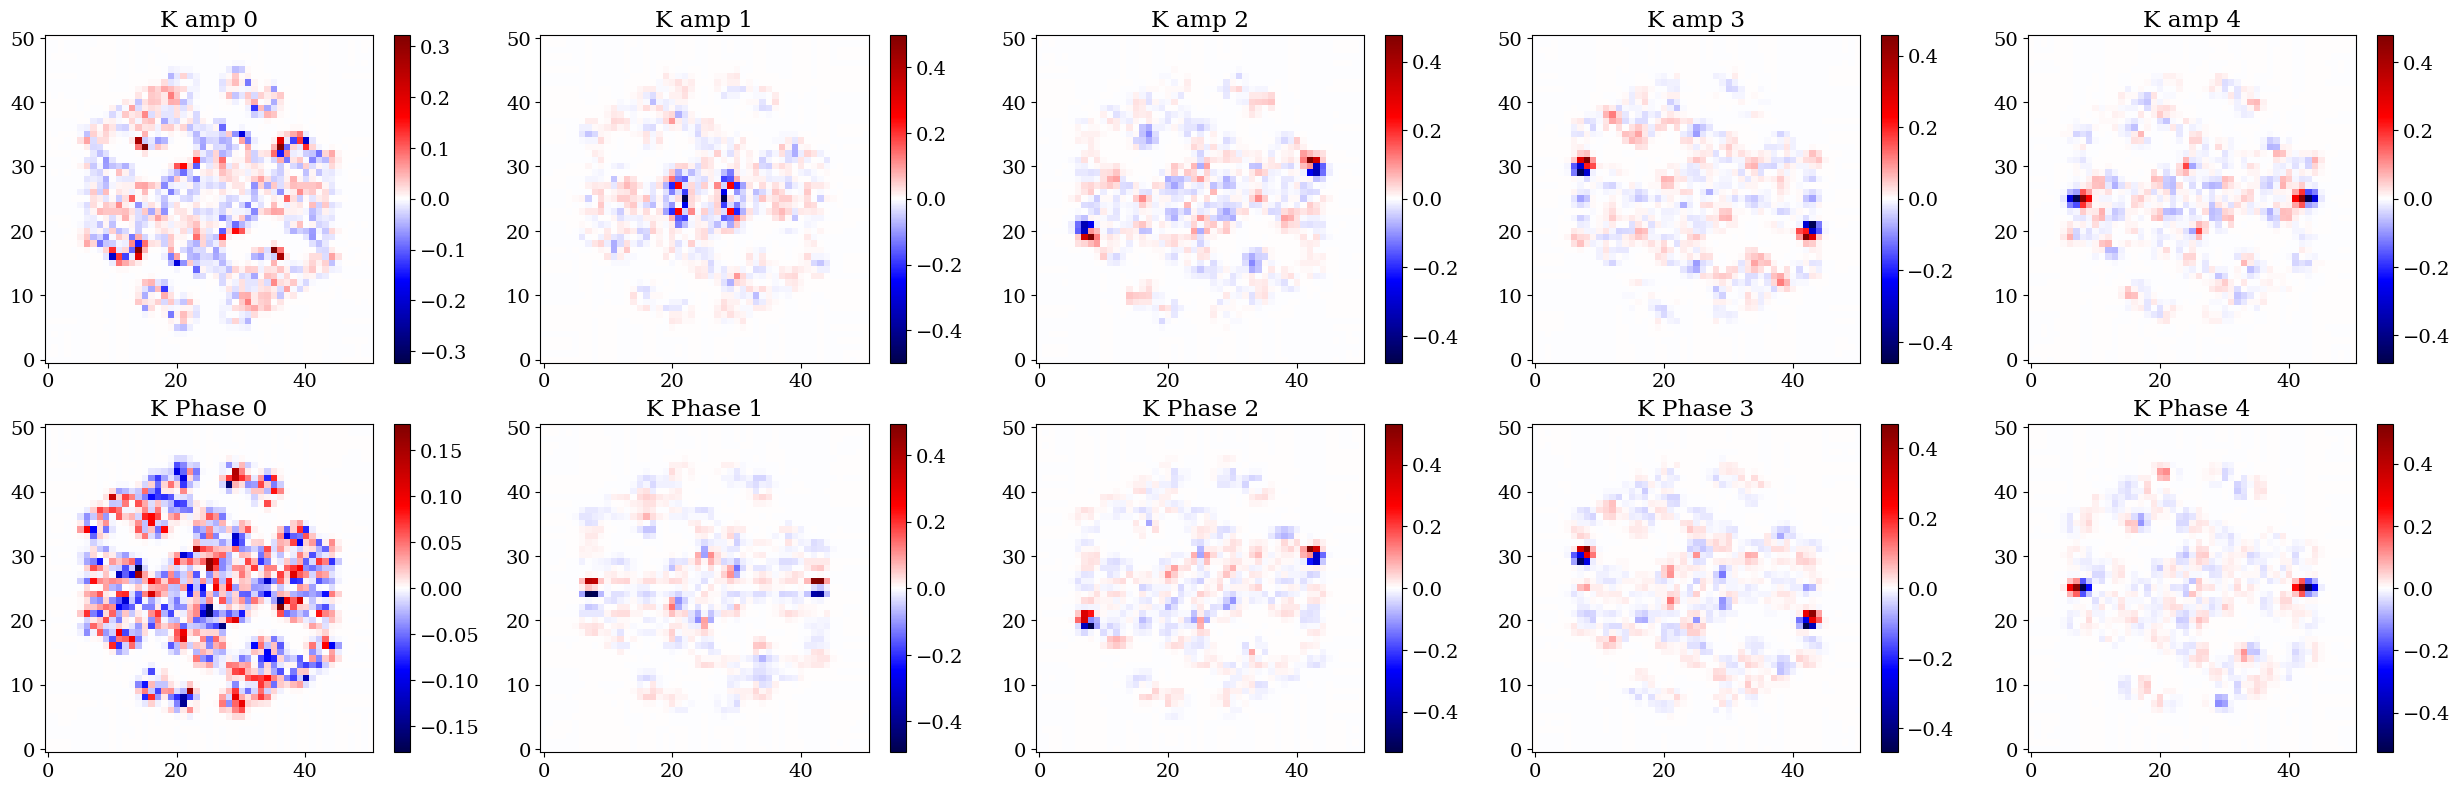

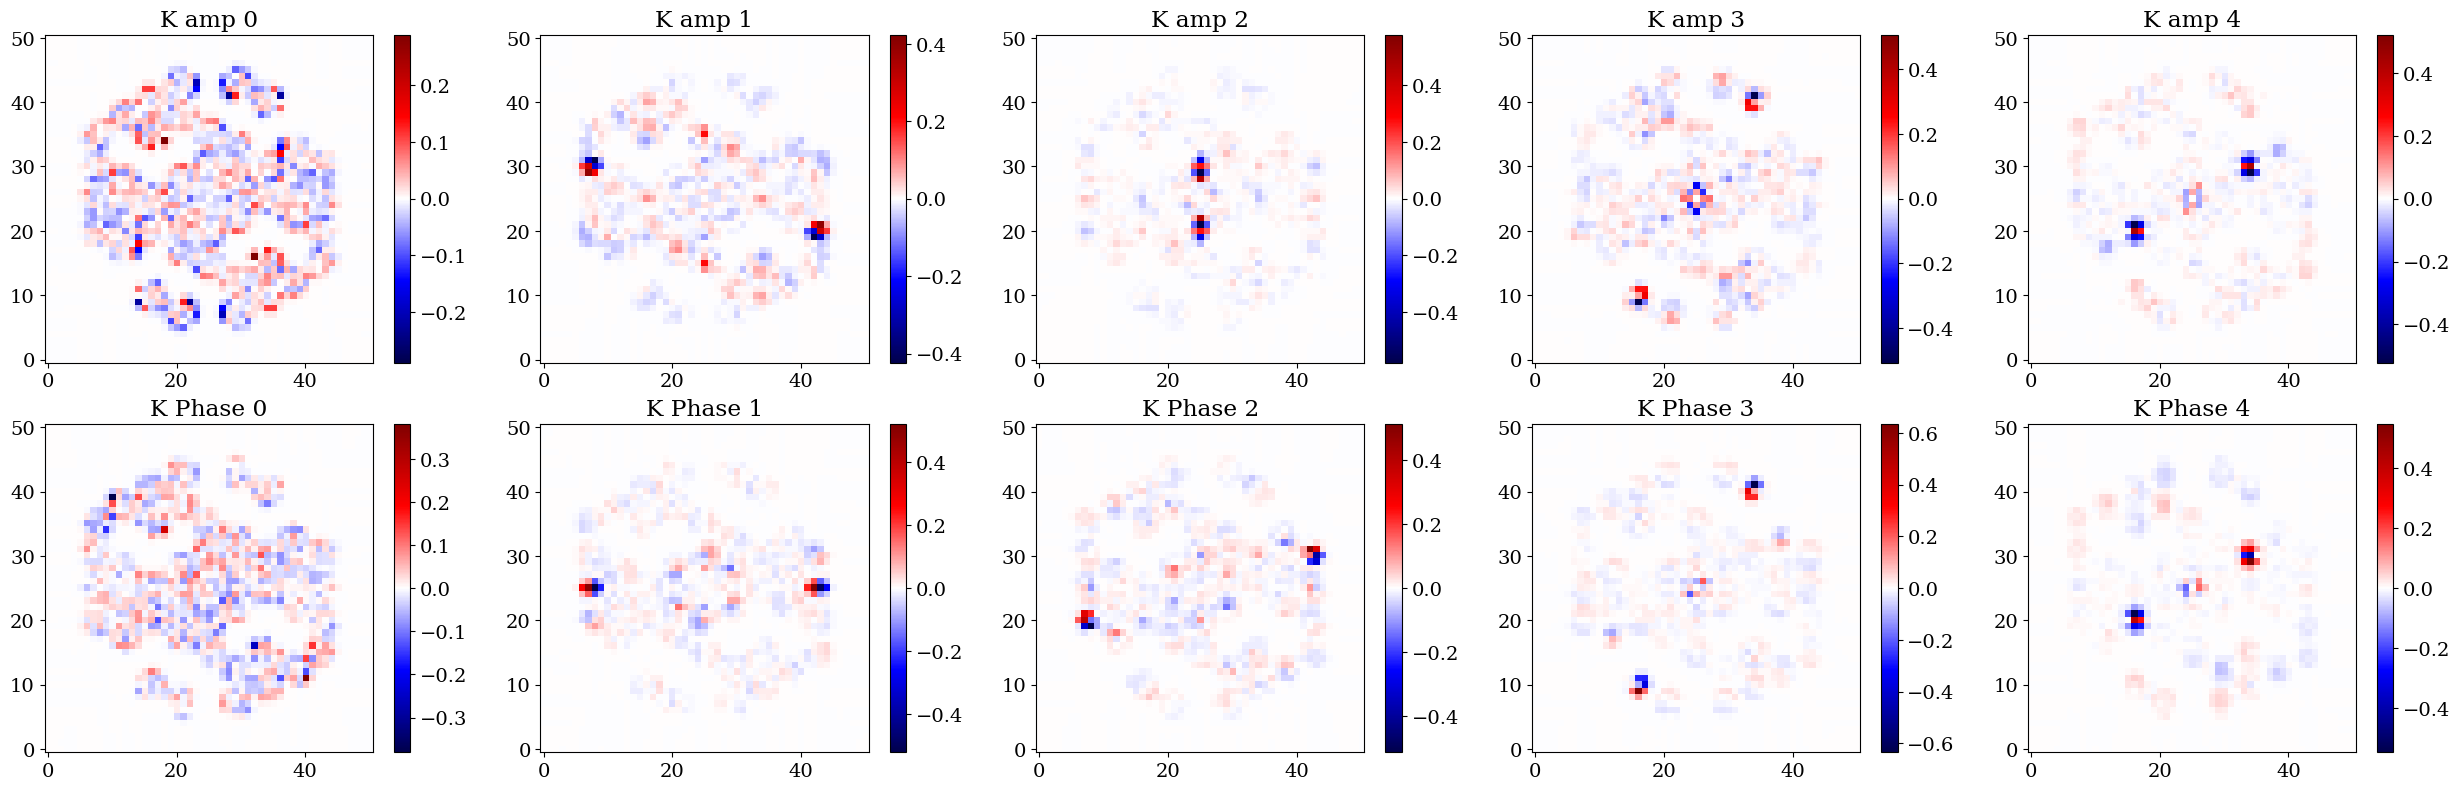

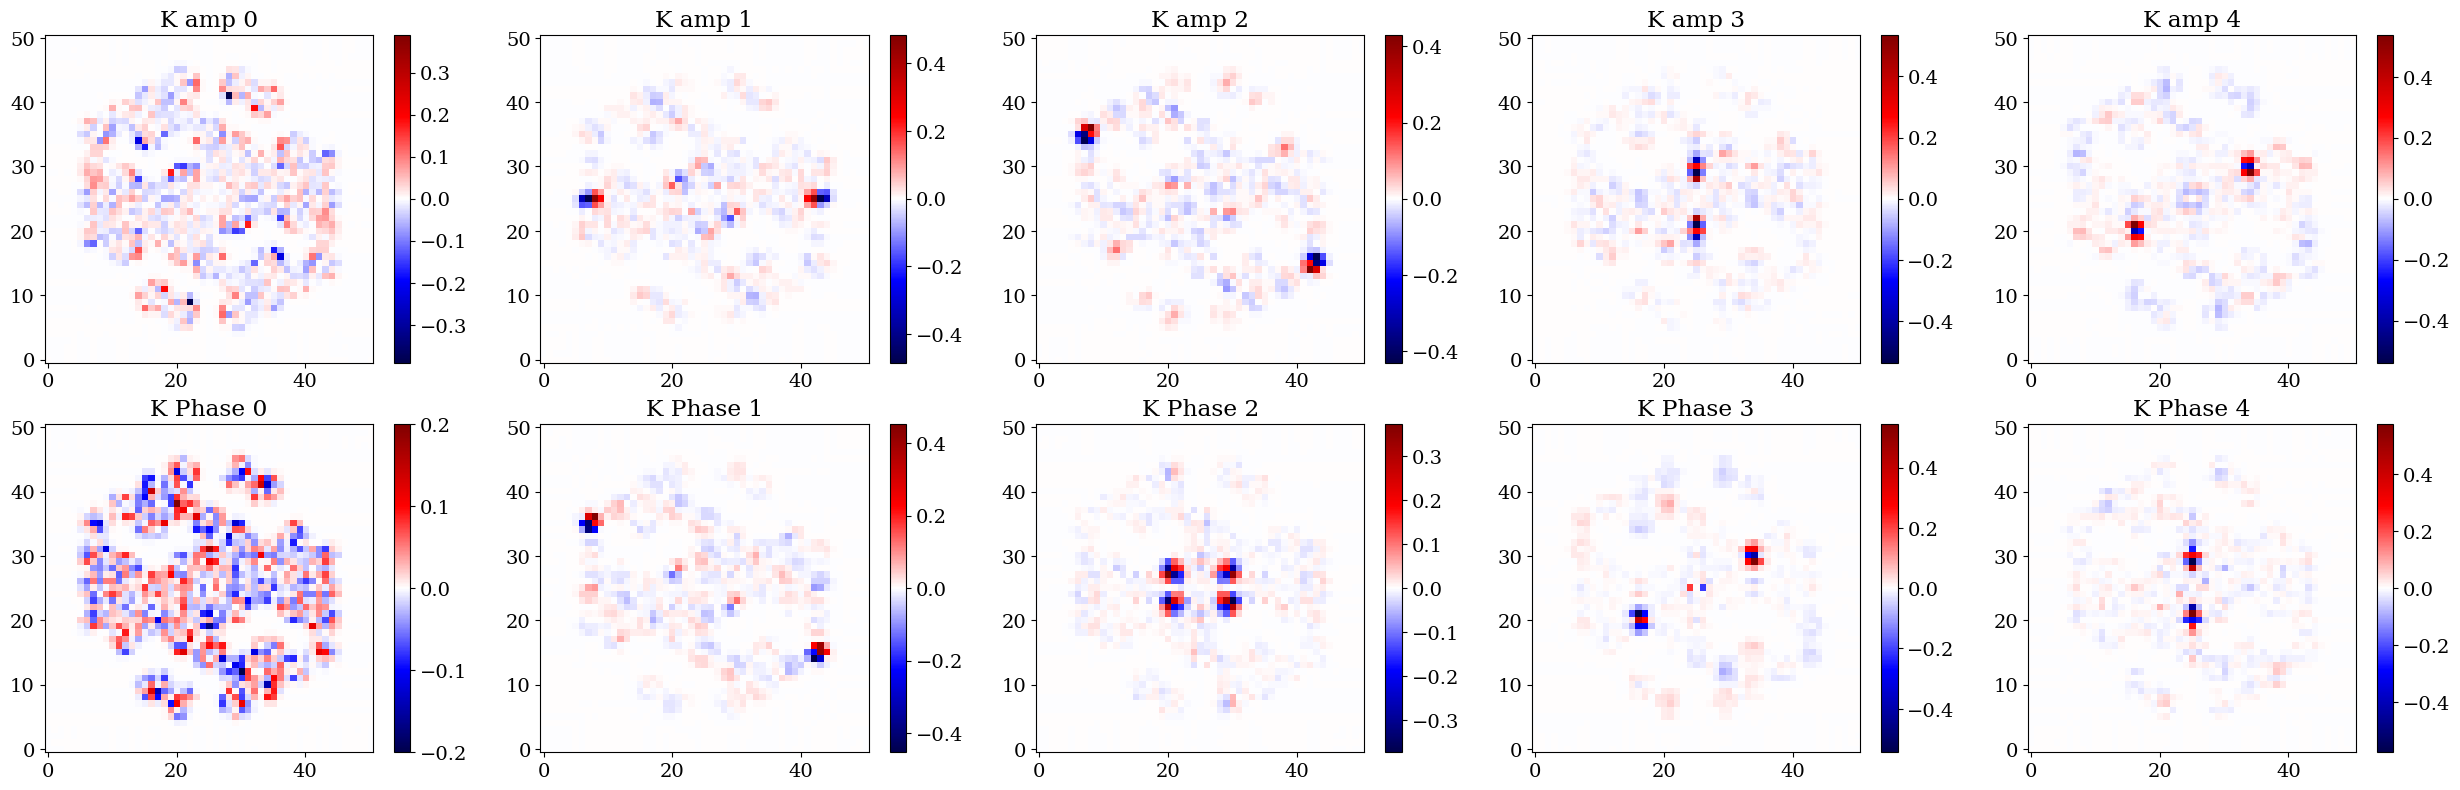

In [9]:
for filt in filters:

    amp_vecs = kernel_outputs[filt]["kernel_mats"]["amplitudes"]
    phase_vecs = kernel_outputs[filt]["kernel_mats"]["phases"]

    plt.figure(figsize=(25, 8))
    for i in range(5):
        log_amp, phase = vis_model.latent_to_im(amp_vecs[i], phase_vecs[i], filt)

        v = np.nanmax(np.abs(log_amp))
        plt.subplot(2, 5, i + 1)
        plt.title(f"K amp {i}")
        plt.imshow(log_amp, seismic, vmin=-v, vmax=v)
        plt.colorbar()

        v = np.nanmax(np.abs(phase))
        plt.subplot(2, 5, i + 6)
        plt.title(f"K Phase {i}")
        plt.imshow(phase, seismic, vmin=-v, vmax=v)
        plt.colorbar()

    plt.tight_layout()
    plt.show()

# Calibrate the Kernel visibilities

In [10]:
from amigo.stats import orthogonalise
from amigo.vis_calibration import get_mean_wavelength, average_vis_fits, calibrate_vis

# Calibrate all the science stars with all the calibrators
cal_stars = list(set([vals["star"] for vals in fit.values() if vals["calibrator"]]))
sci_stars = list(set([vals["star"] for vals in fit.values() if not vals["calibrator"]]))

# Populate the fit dict with the extra values we need
for key, vals in fit.items():
    filt = vals["filter"]
    amp_K = kernel_outputs[filt]["kernel_mats"]["amplitudes"]
    phase_K = kernel_outputs[filt]["kernel_mats"]["phases"]

    full_cov = np.linalg.inv(vals["fishers"])
    amp_cov = full_cov[:n_basis, :n_basis]
    phase_cov = full_cov[n_basis:, n_basis:]

    vals["amp_cov"] = amp_cov
    vals["phase_cov"] = phase_cov
    vals["K_amp"] = np.dot(amp_K, vals["amplitudes"])
    vals["K_phase"] = np.dot(phase_K, vals["phases"])
    vals["K_amp_cov"] = np.dot(amp_K, np.dot(amp_cov, np.linalg.pinv(amp_K)))
    vals["K_phase_cov"] = np.dot(phase_K, np.dot(phase_cov, np.linalg.pinv(phase_K)))

    # Get the spectrally weighted wavelengths
    wavels, filt_weights = optics.filters[filt]
    vals["wavel"] = get_mean_wavelength(wavels, filt_weights, vals["spectra"])


# Average over the multiple exposures
vis_outputs = {}
for i, filt in enumerate(filters):
    for is_cal in [True, False]:
        # Get the list of fits to the right star and filter
        stars_in = cal_stars if is_cal else sci_stars
        star_type = "cal" if is_cal else "sci"
        vis_fits = [vals for vals in fit.values() if vals["star"] in stars_in and vals["filter"] == filt]

        # Ensure we actually have fits to this star/filter
        if len(vis_fits) == 0:
            continue

        # Average the fits
        vis_outputs[f"{star_type}_{filt}"] = average_vis_fits(vis_fits)

# Calibrate the outputs
cal_vis_outputs = {}
for i, filt in enumerate(filters):
    sci_key = f"sci_{filt}"
    cal_key = f"cal_{filt}"
    keys = vis_outputs.keys()
    if sci_key not in keys or cal_key not in keys:
        continue

    # Make sure we aren't averaging over roll angles
    parang_std = vis_outputs[sci_key]["parangs"].std(0)
    assert parang_std < 0.1

    # Calibrate the visibilities
    k_cal_vis_dict = calibrate_vis(vis_outputs, filt, kernel=True)
    cal_vis_dict = calibrate_vis(vis_outputs, filt, kernel=False)

    # Projection matrices
    V_amp = vis_model.V_amp[filt]
    V_phase = vis_model.V_phase[filt]
    K_amp_op = kernel_outputs[filt]["kernel_mats"]["amplitudes"]
    K_phase_op = kernel_outputs[filt]["kernel_mats"]["phases"]

    # Orthonormalise the visibilities
    K_vis = k_cal_vis_dict["K_vis"]
    K_phi = k_cal_vis_dict["K_phi"]
    K_vis_cov = k_cal_vis_dict["K_vis_cov"]
    K_phi_cov = k_cal_vis_dict["K_phi_cov"]
    o_vis, o_vis_cov, o_vis_mat, _ = orthogonalise(K_vis, K_vis_cov)
    o_phi, o_phi_cov, o_phi_mat, _ = orthogonalise(K_phi, K_phi_cov)

    # Save the Orthonormal calibrated Kernel Observables (Ockos)
    o_cal_vis_dict = {
        "O_vis": o_vis,
        "O_phi": o_phi,
        "O_vis_cov": o_vis_cov,
        "O_phi_cov": o_phi_cov,
        "O_vis_mat": o_vis_mat,
        "O_phi_mat": o_phi_mat,
    }

    # uv coordinates
    parang = vis_outputs[sci_key]["parangs"].mean(0)
    wavel = vis_outputs[sci_key]["wavels"].mean(0)

    # Get the coordinates
    n = vis_model.n_knots**2 // 2
    u, v = vis_model.otf_coords.reshape(2, -1)[:, :n]
    u, v = dlu.rotate_coords(np.array([u, -v]), -dlu.deg2rad(parang))

    sci_outputs = {
        "u": u,
        "v": v,
        "vis_mat": V_amp,
        "phi_mat": V_phase,
        "K_vis_mat": K_amp_op,
        "K_phi_mat": K_phase_op,
        "parang": parang,
        "wavel": wavel,
    }

    cal_vis_dict = {**sci_outputs, **o_cal_vis_dict, **k_cal_vis_dict, **cal_vis_dict}
    cal_vis_outputs[filt] = cal_vis_dict
np.save(f"{file_path}/results/GO1843/cal_vis", cal_vis_outputs, allow_pickle=True)

# Examine the outputs

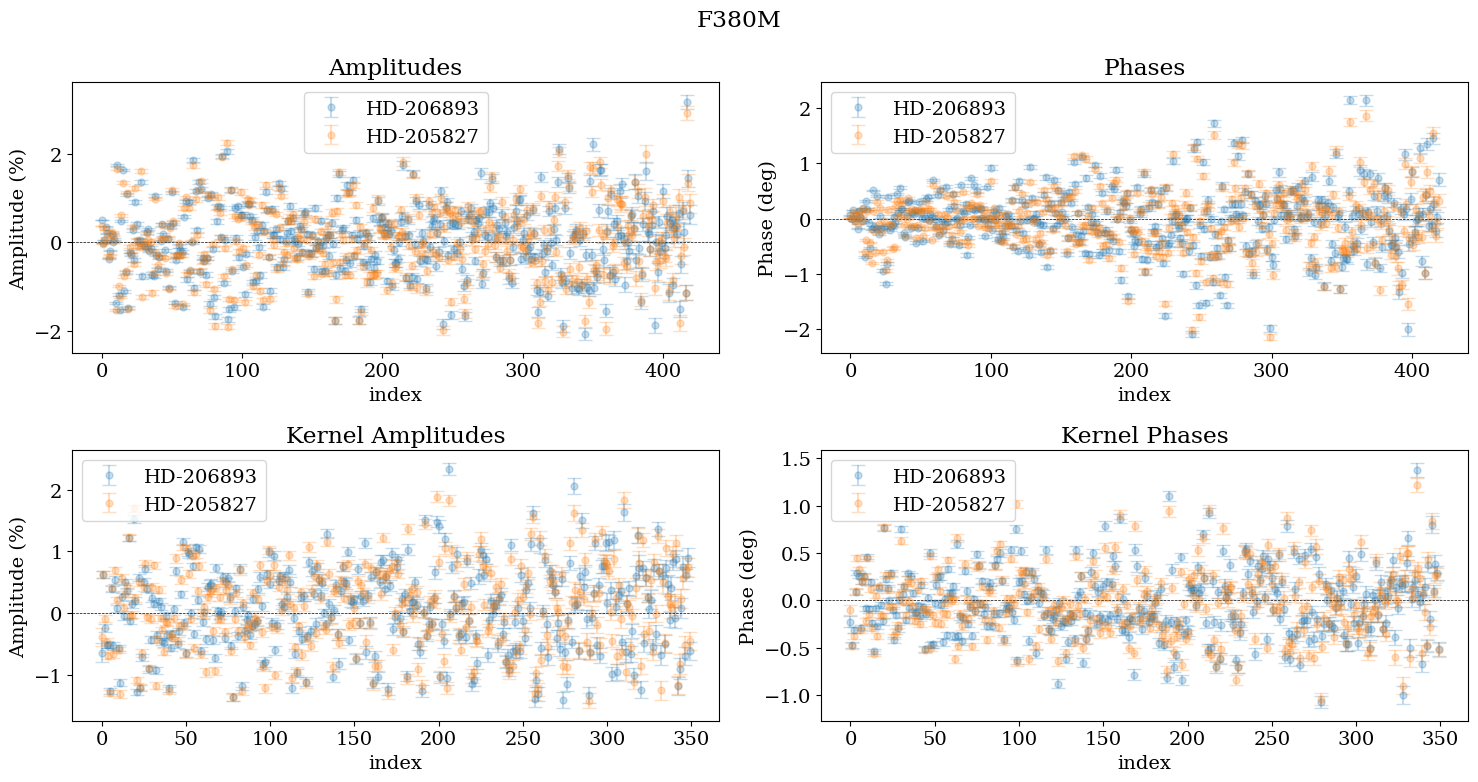

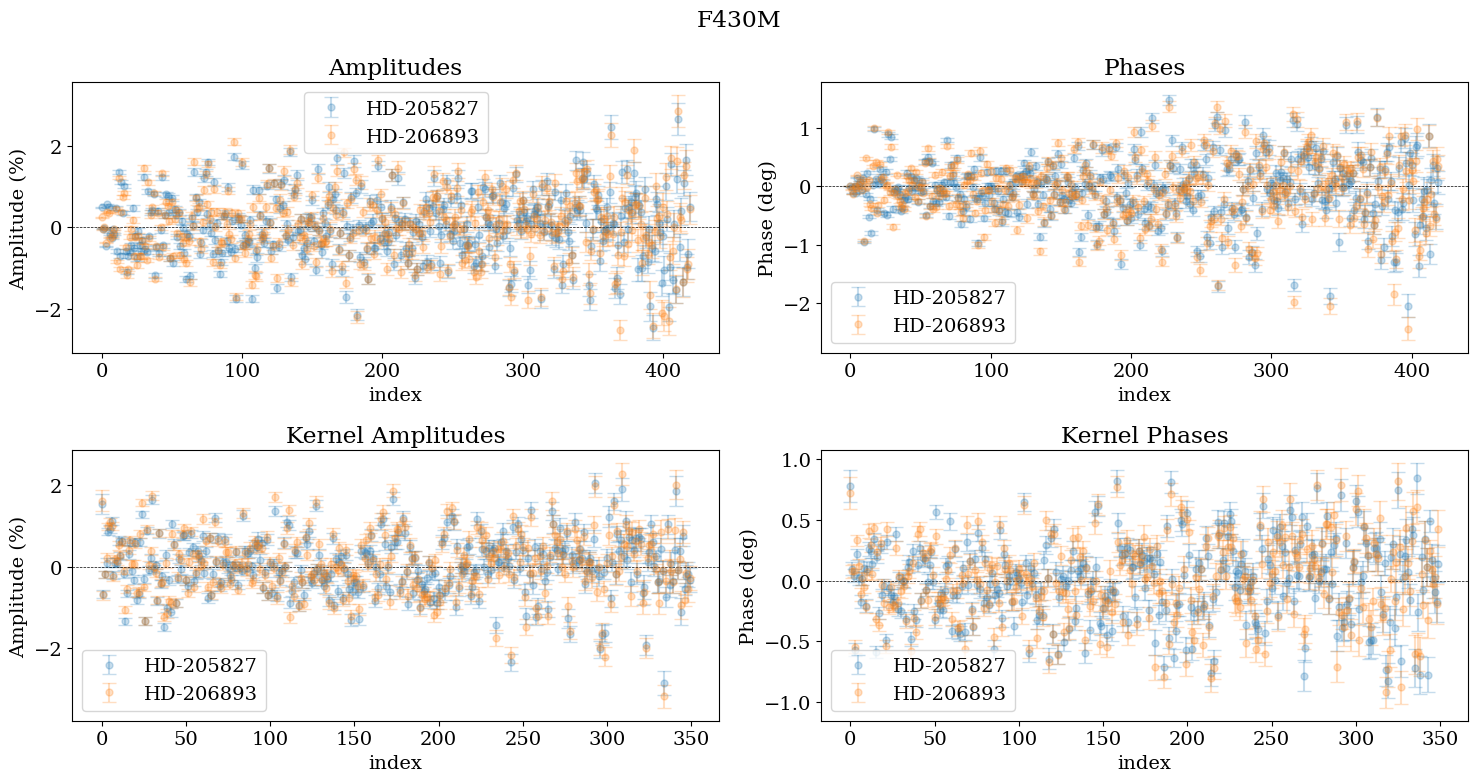

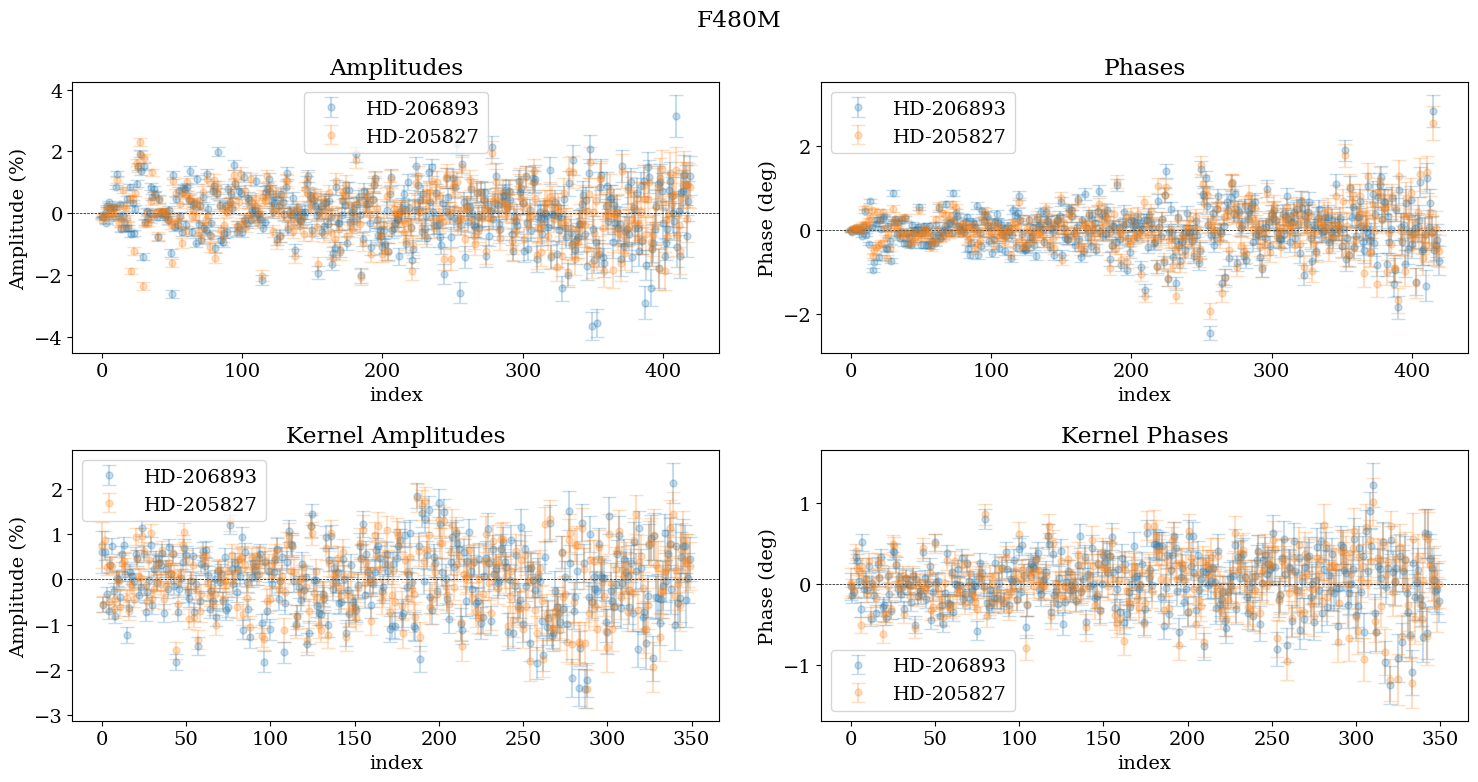

In [11]:
import dLux.utils as dlu

for filt in filters:
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle(f"{filt}")
    axes = fig.subplot_mosaic(
        [
            ["amp", "phase"],
            ["K_amp", "K_phase"],
        ],
    )

    for key, vals in fit.items():

        if vals["filter"] != filt:
            continue

        amp = vals["amplitudes"]
        phase = vals["phases"]
        amp_cov = vals["amp_cov"]
        phase_cov = vals["phase_cov"]

        K_amp = vals["K_amp"]
        K_phase = vals["K_phase"]
        K_amp_cov = vals["K_amp_cov"]
        K_phase_cov = vals["K_phase_cov"]

        amp_err = np.sqrt(np.diag(amp_cov))
        phase_err = np.sqrt(np.diag(phase_cov))
        K_amp_err = np.sqrt(np.diag(K_amp_cov))
        K_phase_err = np.sqrt(np.diag(K_phase_cov))

        #
        amp = 100 * (np.exp(amp) - 1)
        amp_err = 100 * (np.exp(amp_err) - 1)
        K_amp = 100 * (np.exp(K_amp) - 1)
        K_amp_err = 100 * (np.exp(K_amp_err) - 1)

        #
        phase = dlu.rad2deg(phase)
        phase_err = dlu.rad2deg(phase_err)
        K_phase = dlu.rad2deg(K_phase)
        K_phase_err = dlu.rad2deg(K_phase_err)

        inds = np.arange(len(amp))
        K_inds = np.arange(len(K_phase))

        #
        star = vals["star"]
        errorbar = lambda ax, x, y, yerr: ax.errorbar(
            x, y, yerr=yerr, alpha=0.25, label=star, marker="o", capsize=5, ms=5, ls=""
        )
        errorbar(axes["amp"], inds, amp, amp_err)
        errorbar(axes["phase"], inds, phase, phase_err)
        errorbar(axes["K_amp"], K_inds, K_amp, K_amp_err)
        errorbar(axes["K_phase"], K_inds, K_phase, K_phase_err)

    axes["amp"].axhline(0, color="k", ls="--", lw=0.5)
    axes["phase"].axhline(0, color="k", ls="--", lw=0.5)
    axes["K_amp"].axhline(0, color="k", ls="--", lw=0.5)
    axes["K_phase"].axhline(0, color="k", ls="--", lw=0.5)

    axes["amp"].set(ylabel="Amplitude (%)", xlabel="index", title="Amplitudes")
    axes["phase"].set(ylabel="Phase (deg)", xlabel="index", title="Phases")
    axes["K_amp"].set(ylabel="Amplitude (%)", xlabel="index", title="Kernel Amplitudes")
    axes["K_phase"].set(ylabel="Phase (deg)", xlabel="index", title="Kernel Phases")

    axes["amp"].legend()
    axes["phase"].legend()
    axes["K_amp"].legend()
    axes["K_phase"].legend()

    plt.tight_layout()
    plt.show()

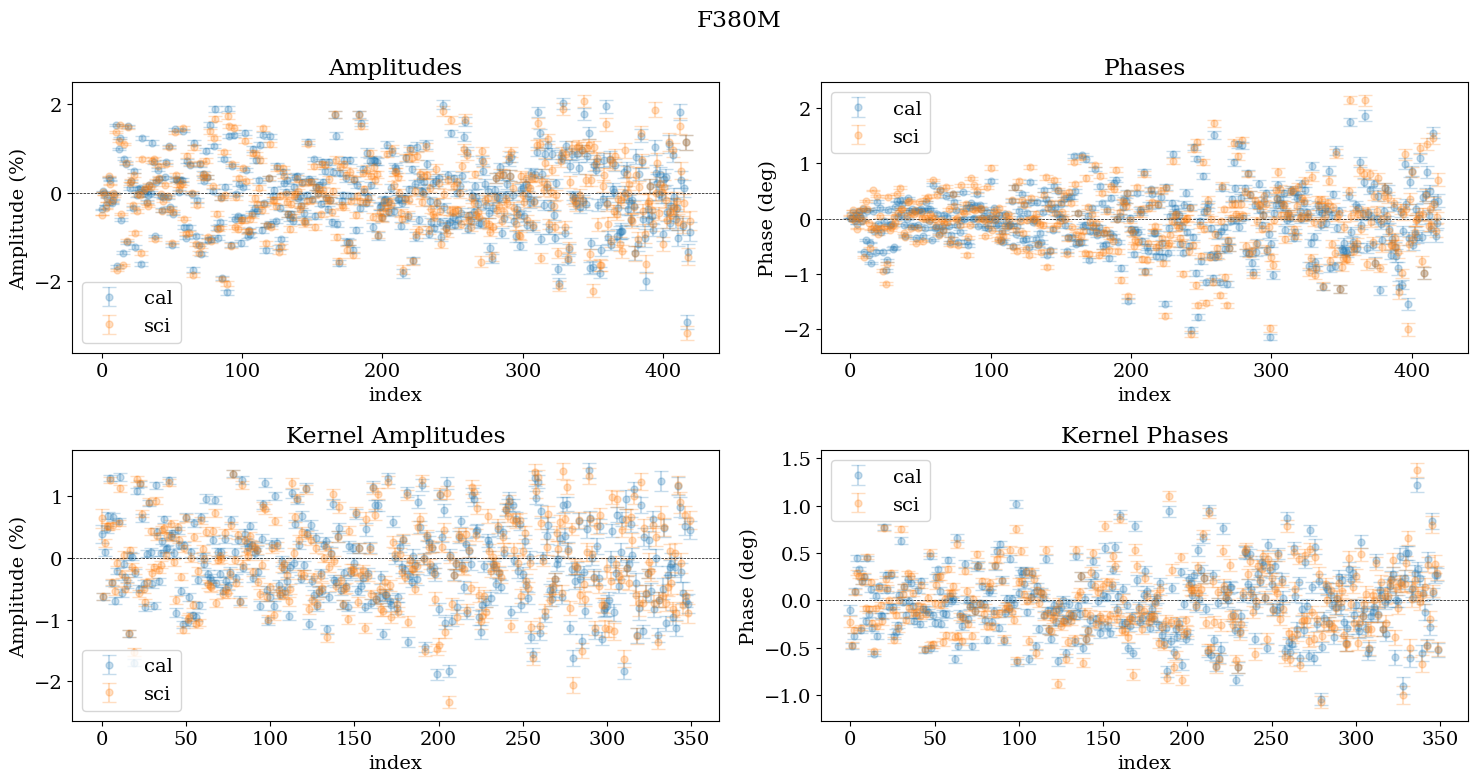

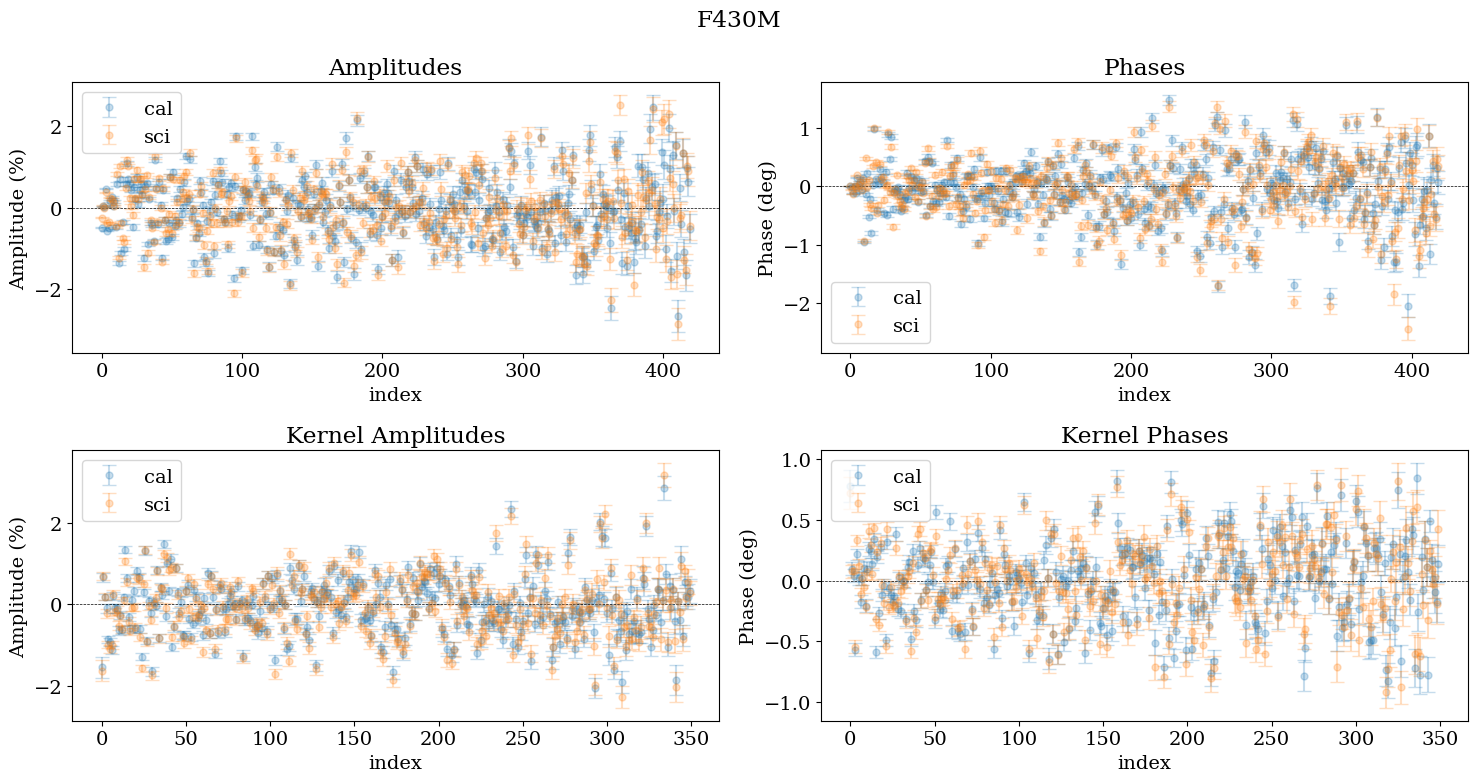

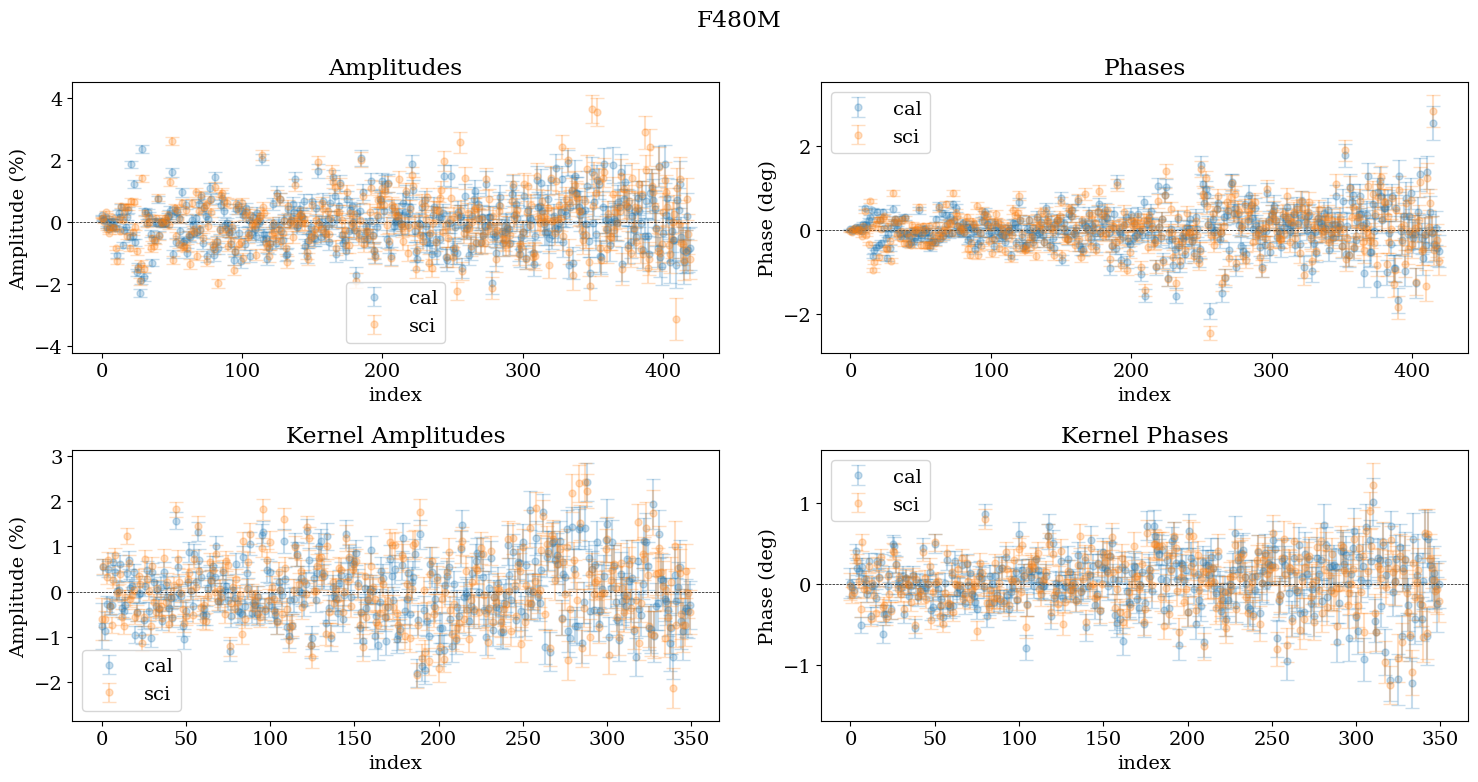

In [12]:
for filt in filters:
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle(f"{filt}")
    axes = fig.subplot_mosaic(
        [
            ["amp", "phase"],
            ["K_amp", "K_phase"],
        ],
    )

    for star_type in ["cal", "sci"]:

        key = f"{star_type}_{filt}"
        if key not in vis_outputs:
            continue

        # cal_vis_outputs
        amps = vis_outputs[key]["vis"]
        phases = vis_outputs[key]["phi"]
        K_amps = vis_outputs[key]["K_vis"]
        K_phases = vis_outputs[key]["K_phi"]
        amp_covs = vis_outputs[key]["vis_cov"]
        phase_covs = vis_outputs[key]["phi_cov"]
        K_amp_covs = vis_outputs[key]["K_vis_cov"]
        K_phase_covs = vis_outputs[key]["K_phi_cov"]

        # Get the errors
        amp_errs = np.sqrt(np.diag(amp_covs))
        phase_errs = np.sqrt(np.diag(phase_covs))
        K_amp_errs = np.sqrt(np.diag(K_amp_covs))
        K_phase_errs = np.sqrt(np.diag(K_phase_covs))

        # Convert to percentage
        amp = 100 * (1 - np.exp(amps))
        amp_err = 100 * (np.exp(amp_errs) - 1)
        K_amp = 100 * (1 - np.exp(K_amps))
        K_amp_err = 100 * (np.exp(K_amp_errs) - 1)

        # Convert to degrees
        phase = dlu.rad2deg(phases)
        phase_err = dlu.rad2deg(phase_errs)
        K_phase = dlu.rad2deg(K_phases)
        K_phase_err = dlu.rad2deg(K_phase_errs)

        inds = np.arange(len(amps))
        K_inds = np.arange(len(K_phase))

        # Plot the results
        axes["amp"].errorbar(inds, amp, yerr=amp_err, alpha=0.25, label=star_type, marker="o", capsize=5, ms=5, ls='')
        axes["phase"].errorbar(inds, phase, yerr=phase_err, alpha=0.25, label=star_type, marker="o", capsize=5, ms=5, ls='')
        axes["K_amp"].errorbar(K_inds, K_amp, yerr=K_amp_err, alpha=0.25, label=star_type, marker="o", capsize=5, ms=5, ls='')
        axes["K_phase"].errorbar(K_inds, K_phase, yerr=K_phase_err, alpha=0.25, label=star_type, marker="o", capsize=5, ms=5, ls='')

    cal_K_amp = vis_outputs[f"sci_{filt}"]["K_vis"] - vis_outputs[f"cal_{filt}"]["K_vis"]
    cal_K_phase = vis_outputs[f"sci_{filt}"]["K_phi"] - vis_outputs[f"cal_{filt}"]["K_phi"]
    cal_K_amp = 100 * (1 - np.exp(cal_K_amp))
    cal_K_phase = dlu.rad2deg(cal_K_phase)

    K_amp_err = np.sqrt(np.diag(vis_outputs[f"sci_{filt}"]["K_vis_cov"] + vis_outputs[f"cal_{filt}"]["K_vis_cov"]))
    K_phase_err = np.sqrt(np.diag(vis_outputs[f"sci_{filt}"]["K_phi_cov"] + vis_outputs[f"cal_{filt}"]["K_phi_cov"]))
    K_amp_err = 100 * (np.exp(K_amp_err) - 1)
    K_phase_err = dlu.rad2deg(K_phase_err)


    axes["amp"].axhline(0, color="k", ls="--", lw=0.5)
    axes["phase"].axhline(0, color="k", ls="--", lw=0.5)
    axes["K_amp"].axhline(0, color="k", ls="--", lw=0.5)
    axes["K_phase"].axhline(0, color="k", ls="--", lw=0.5)

    axes["amp"].set(ylabel="Amplitude (%)", xlabel="index", title="Amplitudes")
    axes["phase"].set(ylabel="Phase (deg)", xlabel="index", title="Phases")
    axes["K_amp"].set(ylabel="Amplitude (%)", xlabel="index", title="Kernel Amplitudes")
    axes["K_phase"].set(ylabel="Phase (deg)", xlabel="index", title="Kernel Phases")

    axes["amp"].legend()
    axes["phase"].legend()
    axes["K_amp"].legend()
    axes["K_phase"].legend()

    fig.tight_layout()
    fig.show()

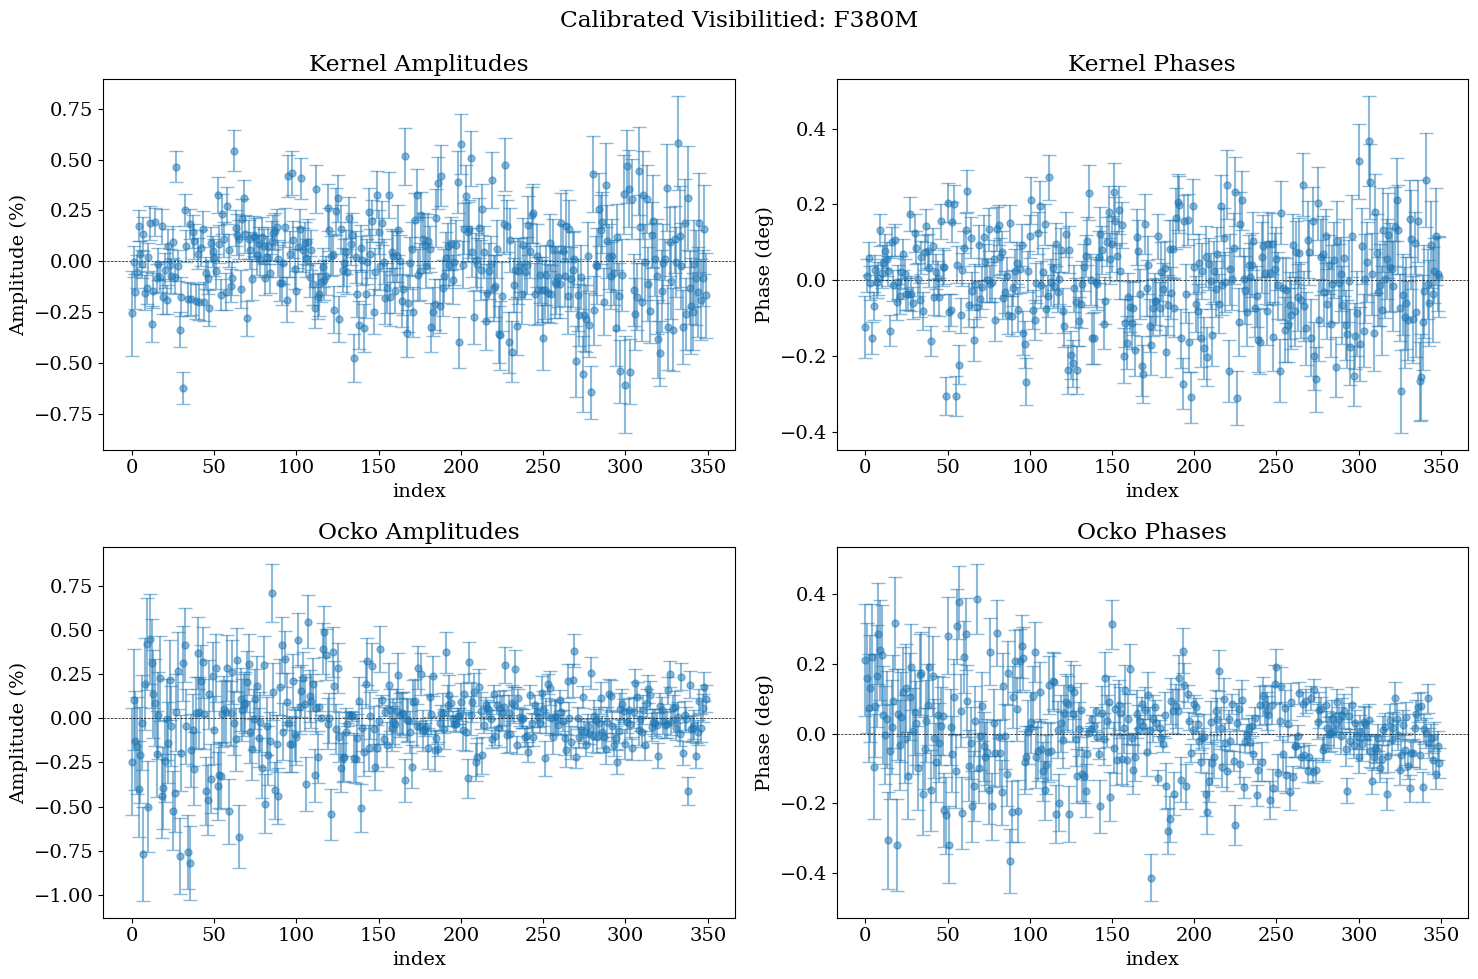

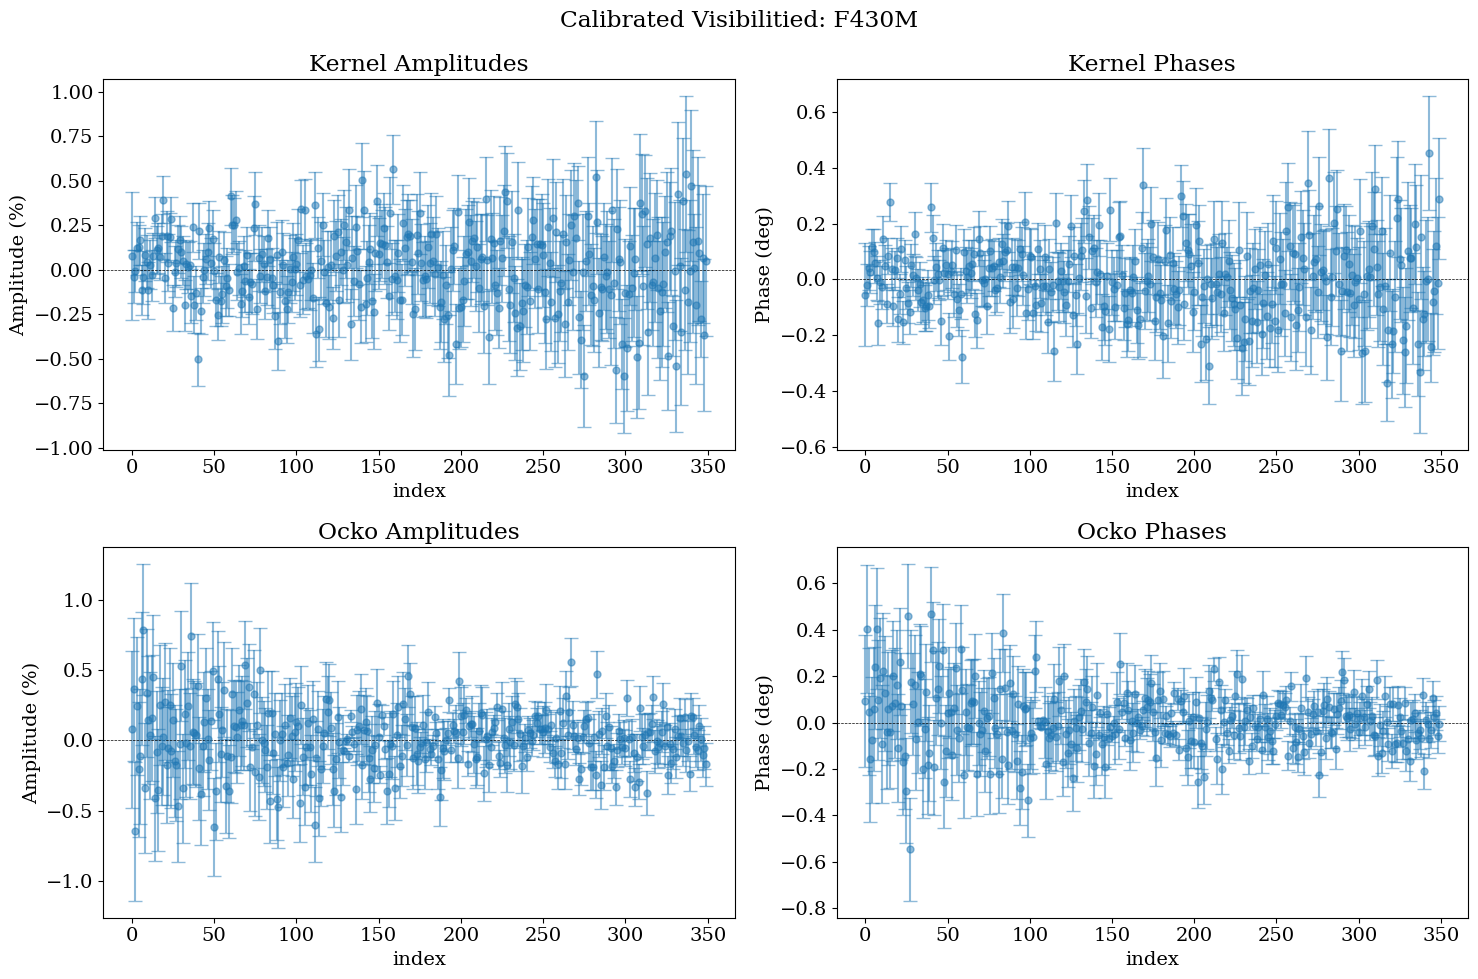

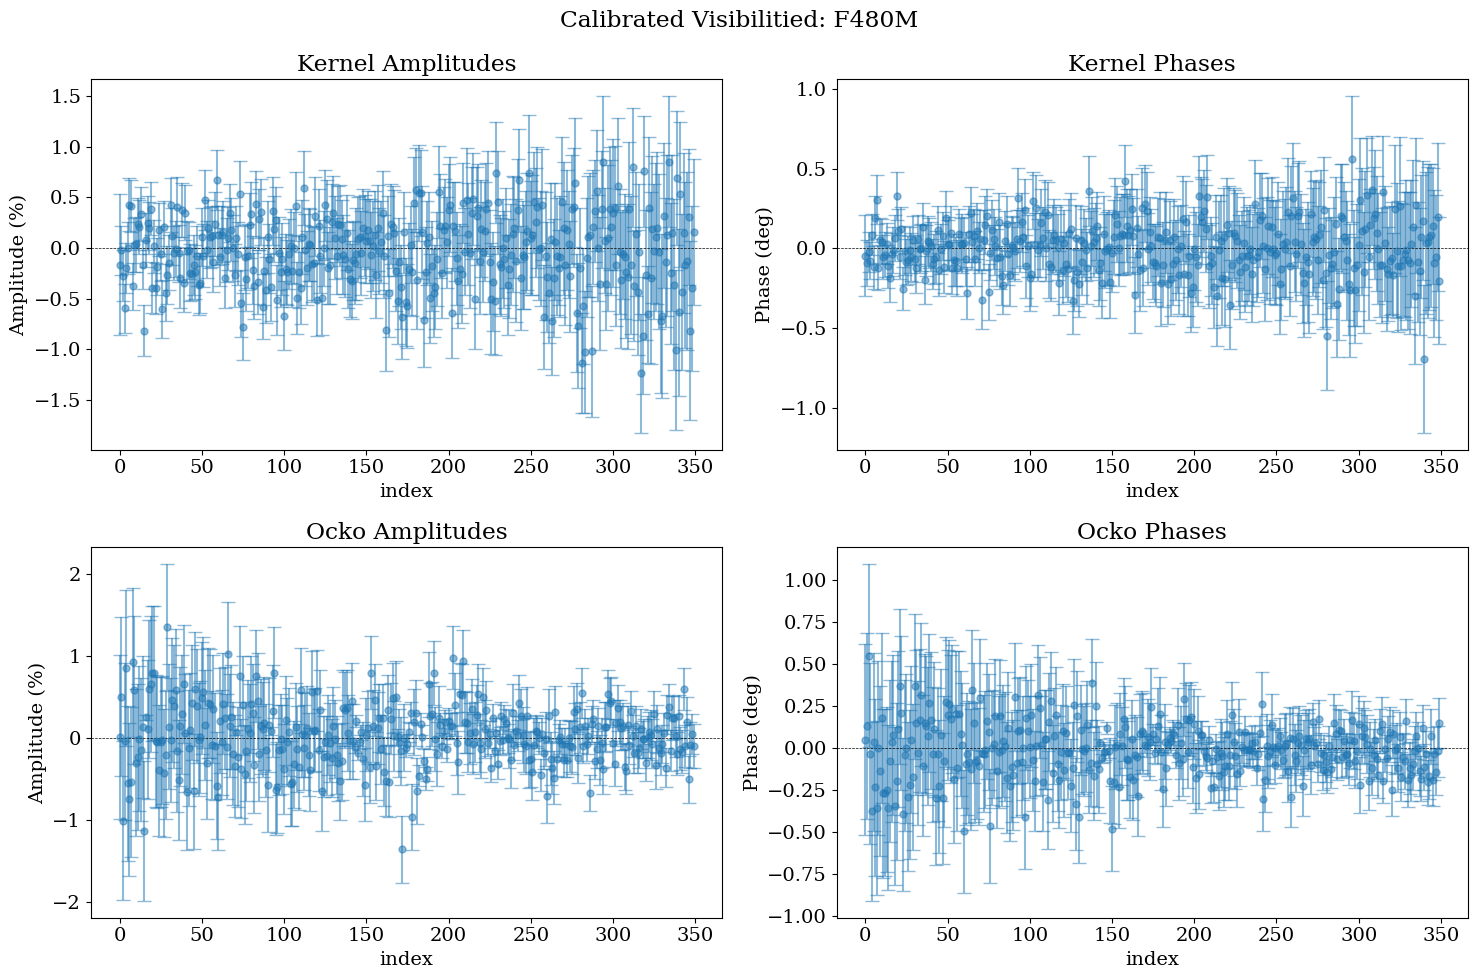

In [13]:
for filt in filters:
    if filt not in cal_vis_outputs.keys():
        continue

    K_amp = cal_vis_outputs[filt]["K_vis"]
    K_phase = cal_vis_outputs[filt]["K_phi"]
    K_amp_cov = cal_vis_outputs[filt]["K_vis_cov"]
    K_phase_cov = cal_vis_outputs[filt]["K_phi_cov"]

    O_amp = cal_vis_outputs[filt]["O_vis"]
    O_phase = cal_vis_outputs[filt]["O_phi"]
    O_amp_cov = cal_vis_outputs[filt]["O_vis_cov"]
    O_phase_cov = cal_vis_outputs[filt]["O_phi_cov"]

    # Get the errors
    K_amp_err = np.sqrt(np.diag(K_amp_cov))
    K_phase_err = np.sqrt(np.diag(K_phase_cov))
    O_amp_err = np.sqrt(np.diag(O_amp_cov))
    O_phase_err = np.sqrt(np.diag(O_phase_cov))

    # Scale to appropriate units
    K_amp = 100 * (np.exp(K_amp) - 1)
    K_phase = dlu.rad2deg(K_phase)
    K_amp_err = 100 * (np.exp(K_amp_err) - 1)
    K_phase_err = dlu.rad2deg(K_phase_err)

    O_amp = 100 * (np.exp(O_amp) - 1)
    O_phase = dlu.rad2deg(O_phase)
    O_amp_err = 100 * (np.exp(O_amp_err) - 1)
    O_phase_err = dlu.rad2deg(O_phase_err)

    inds = np.arange(len(K_phase))

    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(f"Calibrated Visibilitied: {filt}")

    axes = fig.subplot_mosaic(
        [
            ["K_amp", "K_phase"],
            ["O_amp", "O_phase"],
        ],
    )

    #
    axes["K_amp"].errorbar(inds, K_amp, yerr=K_amp_err, alpha=0.5, label=filt, marker="o", capsize=5, ms=5, ls='')
    axes["K_phase"].errorbar(inds, K_phase, yerr=K_phase_err, alpha=0.5, label=filt, marker="o", capsize=5, ms=5, ls='')
    axes["O_amp"].errorbar(inds, O_amp, yerr=O_amp_err, alpha=0.5, label=filt, marker="o", capsize=5, ms=5, ls='')
    axes["O_phase"].errorbar(inds, O_phase, yerr=O_phase_err, alpha=0.5, label=filt, marker="o", capsize=5, ms=5, ls='')

    axes["K_amp"].axhline(0, color="k", ls="--", lw=0.5)
    axes["K_phase"].axhline(0, color="k", ls="--", lw=0.5)
    axes["O_amp"].axhline(0, color="k", ls="--", lw=0.5)
    axes["O_phase"].axhline(0, color="k", ls="--", lw=0.5)

    axes["K_amp"].set(ylabel="Amplitude (%)", xlabel="index", title="Kernel Amplitudes")
    axes["K_phase"].set(ylabel="Phase (deg)", xlabel="index", title="Kernel Phases")
    axes["O_amp"].set(ylabel="Amplitude (%)", xlabel="index", title="Ocko Amplitudes")
    axes["O_phase"].set(ylabel="Phase (deg)", xlabel="index", title="Ocko Phases")

    fig.tight_layout()
    fig.show()

(51, 51)


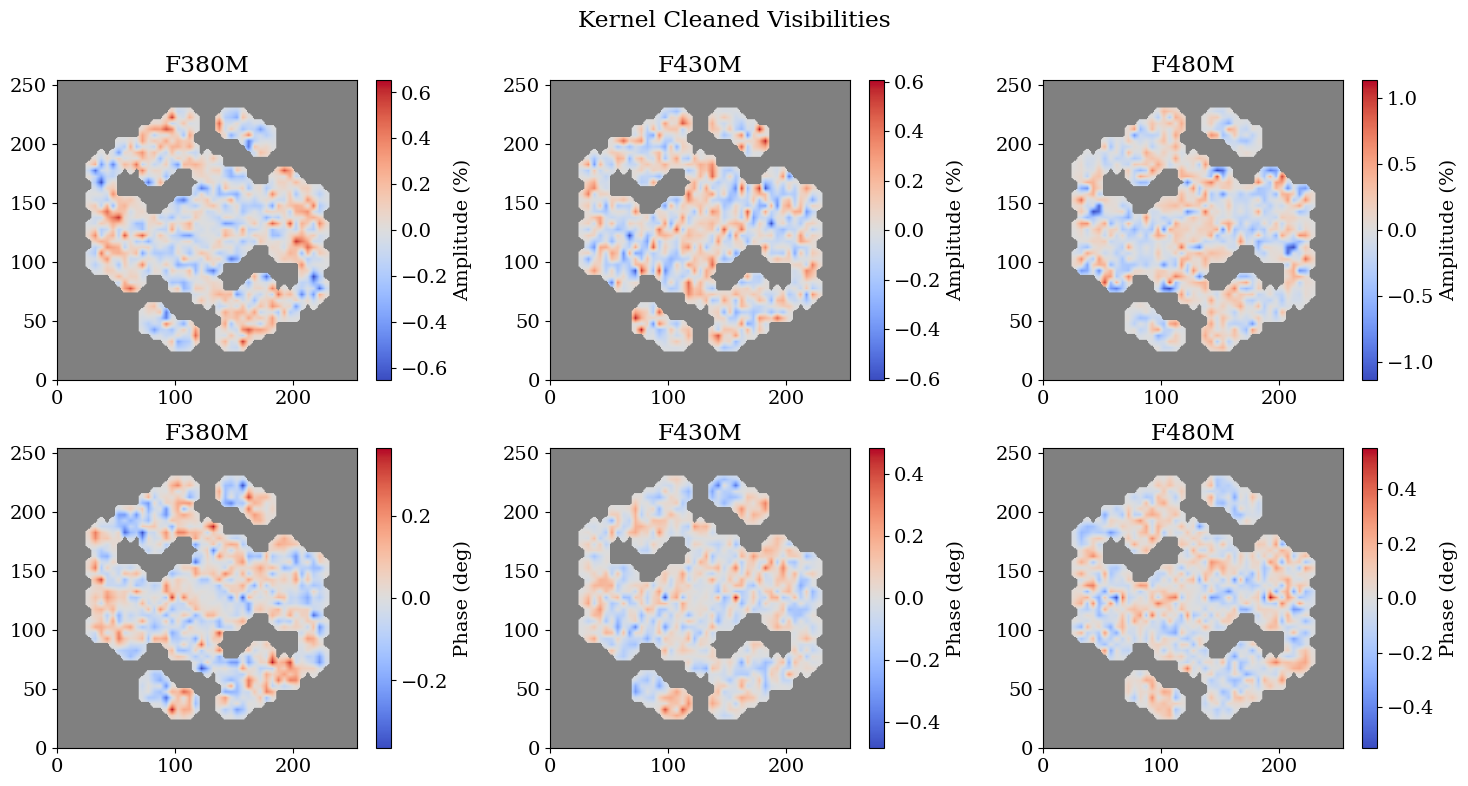

In [14]:
from amigo.misc import interp
from jax.scipy.signal import correlate
from amigo.vis_models import vis_to_im

# mask = optics.pupil_mask.calc_mask(optics.wf_npixels, optics.diameter)
mask = optics.pupil_mask.transmission
mask = dlu.downsample(mask, 8, mean=True)
splodges = correlate(mask, mask, method="fft")
splodges /= splodges.max()
splodges = dlu.downsample(splodges, 5, mean=False)
otf_mask = (splodges > 0.25).astype(float)

print(otf_mask.shape)


plt.figure(figsize=(15, 8))
plt.suptitle("Kernel Cleaned Visibilities")
for i, filt in enumerate(cal_vis_outputs.keys()):
    K_vis = cal_vis_outputs[filt]["K_vis"]
    K_phi = cal_vis_outputs[filt]["K_phi"]
    K_vis_mat = cal_vis_outputs[filt]["K_vis_mat"]
    K_phi_mat = cal_vis_outputs[filt]["K_phi_mat"]
    vis_mat = cal_vis_outputs[filt]["vis_mat"]
    phi_mat = cal_vis_outputs[filt]["phi_mat"]

    vis = np.dot(np.linalg.pinv(K_vis_mat), K_vis)
    phi = np.dot(np.linalg.pinv(K_phi_mat), K_phi)

    vis_pix = np.dot(vis, vis_mat)
    phi_pix = np.dot(phi, phi_mat)

    log_amps, phases = vis_to_im(vis_pix, phi_pix, (51, 51))

    knots = dlu.pixel_coords(51, 2)
    samples = dlu.pixel_coords(255, 2)
    log_amps = interp(log_amps, knots, samples)
    phases = interp(phases, knots, samples)


    full_otf = interp(otf_mask, knots, samples)
    log_amps = np.where(full_otf > 0.25, log_amps, np.nan)
    phases = np.where(full_otf > 0.25, phases, np.nan)

    amp = 100 * (np.exp(log_amps) - 1)
    phase = dlu.rad2deg(phases)

    v = np.nanmax(np.abs(amp))
    plt.subplot(2, 3, i + 1)
    plt.title(f"{filt}")
    plt.imshow(amp, coolwarm, vmin=-v, vmax=v)
    plt.colorbar(label="Amplitude (%)")

    v = np.nanmax(np.abs(phase))
    plt.subplot(2, 3, i + 4)
    plt.title(f"{filt}")
    plt.imshow(phase, coolwarm, vmin=-v, vmax=v)
    plt.colorbar(label="Phase (deg)")

plt.tight_layout()
plt.show()

(51, 51)


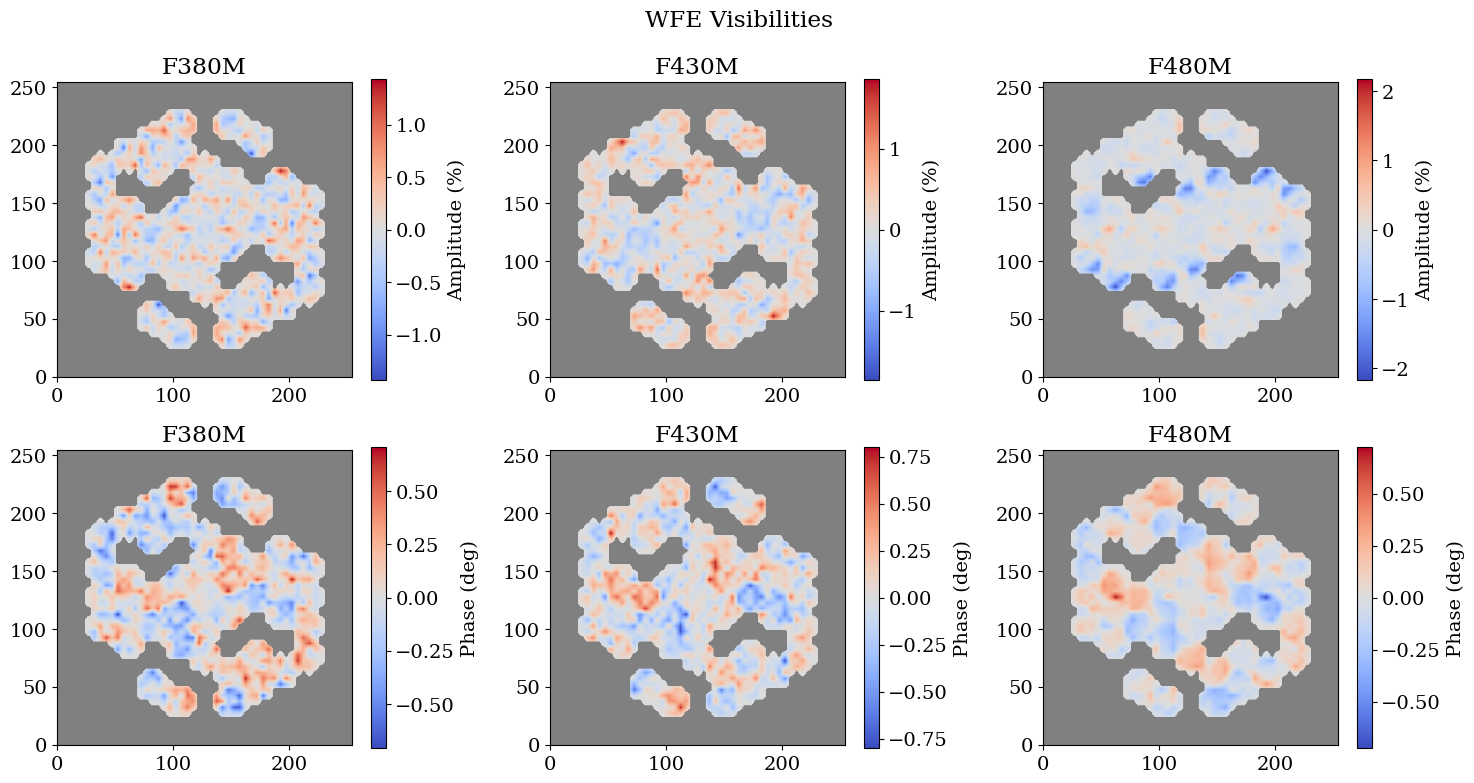

: 

In [ ]:
from amigo.misc import interp

from jax.scipy.signal import correlate

# mask = optics.pupil_mask.calc_mask(optics.wf_npixels, optics.diameter)
mask = optics.pupil_mask.transmission
mask = dlu.downsample(mask, 8, mean=True)
splodges = correlate(mask, mask, method="fft")
splodges /= splodges.max()
splodges = dlu.downsample(splodges, 5, mean=False)
otf_mask = (splodges > 0.25).astype(float)

print(otf_mask.shape)


plt.figure(figsize=(15, 8))
plt.suptitle("WFE Visibilities")
for i, filt in enumerate(cal_vis_outputs.keys()):
    raw_vis = cal_vis_outputs[filt]["vis"]
    raw_phi = cal_vis_outputs[filt]["phi"]

    #
    vis = cal_vis_outputs[filt]["vis"]
    phi = cal_vis_outputs[filt]["phi"]
    vis_mat = cal_vis_outputs[filt]["vis_mat"]
    phi_mat = cal_vis_outputs[filt]["phi_mat"]

    #
    vis_mat = cal_vis_outputs[filt]["vis_mat"]
    phi_mat = cal_vis_outputs[filt]["phi_mat"]


    vis = np.dot(np.linalg.pinv(K_vis_mat), K_vis)
    phi = np.dot(np.linalg.pinv(K_phi_mat), K_phi)

    vis_pix = np.dot(raw_vis, vis_mat) - np.dot(vis, vis_mat)
    phi_pix = np.dot(raw_phi, phi_mat) - np.dot(phi, phi_mat)

    log_amps, phases = vis_to_im(vis_pix, phi_pix, (51, 51))

    knots = dlu.pixel_coords(51, 2)
    samples = dlu.pixel_coords(255, 2)
    log_amps = interp(log_amps, knots, samples)
    phases = interp(phases, knots, samples)

    full_otf = interp(otf_mask, knots, samples)
    log_amps = np.where(full_otf > 0.25, log_amps, np.nan)
    phases = np.where(full_otf > 0.25, phases, np.nan)

    amp = 100 * (np.exp(log_amps) - 1)
    phase = dlu.rad2deg(phases)

    v = np.nanmax(np.abs(amp))
    plt.subplot(2, 3, i + 1)
    plt.title(f"{filt}")
    plt.imshow(amp, coolwarm, vmin=-v, vmax=v)
    plt.colorbar(label="Amplitude (%)")

    v = np.nanmax(np.abs(phase))
    plt.subplot(2, 3, i + 4)
    plt.title(f"{filt}")
    plt.imshow(phase, coolwarm, vmin=-v, vmax=v)
    plt.colorbar(label="Phase (deg)")

plt.tight_layout()
plt.show()